In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-resnet50-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = ResNet50(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 102s - loss: 0.9851 - acc: 0.7883 - val_loss: 9.8430 - val_acc: 0.0392
Epoch 2/100
8394/8394 [==============================] - 87s - loss: 0.2196 - acc: 0.9411 - val_loss: 1.0759 - val_acc: 0.7661
Epoch 3/100
8394/8394 [==============================] - 86s - loss: 0.1606 - acc: 0.9554 - val_loss: 3.4519 - val_acc: 0.5608
Epoch 4/100
8394/8394 [==============================] - 86s - loss: 0.0871 - acc: 0.9740 - val_loss: 0.2289 - val_acc: 0.9481
Epoch 5/100
8394/8394 [==============================] - 87s - loss: 0.0761 - acc: 0.9778 - val_loss: 0.1432 - val_acc: 0.9492
Epoch 6/100
8394/8394 [==============================] - 87s - loss: 0.0673 - acc: 0.9786 - val_loss: 0.1417 - val_acc: 0.9545
Epoch 7/100
8394/8394 [==============================] - 86s - loss: 0.1228 - acc: 0.9666 - val_loss: 3.4505 - val_acc: 0.5101
Epoch 8/100
8394/8394 [==============================] - 86s - 

8397/8397 [==============================] - 84s - loss: 0.0650 - acc: 0.9808 - val_loss: 0.0593 - val_acc: 0.9788
Epoch 27/100
8397/8397 [==============================] - 84s - loss: 0.0515 - acc: 0.9852 - val_loss: 0.0756 - val_acc: 0.9745
Epoch 28/100
8397/8397 [==============================] - 84s - loss: 0.0592 - acc: 0.9842 - val_loss: 0.0826 - val_acc: 0.9692
Epoch 29/100
8397/8397 [==============================] - 84s - loss: 0.0897 - acc: 0.9734 - val_loss: 0.0683 - val_acc: 0.9777
Epoch 30/100
8397/8397 [==============================] - 84s - loss: 0.0620 - acc: 0.9815 - val_loss: 0.0564 - val_acc: 0.9798
Epoch 31/100
8397/8397 [==============================] - 84s - loss: 0.0534 - acc: 0.9851 - val_loss: 0.0520 - val_acc: 0.9820
Epoch 32/100
8397/8397 [==============================] - 84s - loss: 0.0509 - acc: 0.9845 - val_loss: 0.0633 - val_acc: 0.9777
Epoch 33/100
8397/8397 [==============================] - 84s - loss: 0.0403 - acc: 0.9882 - val_loss: 0.0303 - val_a

8401/8401 [==============================] - 84s - loss: 0.0099 - acc: 0.9992 - val_loss: 0.0627 - val_acc: 0.9904
Epoch 54/100
8401/8401 [==============================] - 84s - loss: 0.1559 - acc: 0.9768 - val_loss: 0.1507 - val_acc: 0.9648
Epoch 55/100
8401/8401 [==============================] - 84s - loss: 0.0252 - acc: 0.9931 - val_loss: 7.6633 - val_acc: 0.5075
Epoch 56/100
8401/8401 [==============================] - 84s - loss: 0.0185 - acc: 0.9943 - val_loss: 1.2580 - val_acc: 0.8156
Epoch 57/100
8401/8401 [==============================] - 84s - loss: 0.0084 - acc: 0.9968 - val_loss: 0.0610 - val_acc: 0.9883
Epoch 58/100
8401/8401 [==============================] - 84s - loss: 0.0091 - acc: 0.9965 - val_loss: 0.0661 - val_acc: 0.9872
Epoch 59/100
8401/8401 [==============================] - 84s - loss: 0.0046 - acc: 0.9990 - val_loss: 0.0781 - val_acc: 0.9861
Epoch 60/100
8401/8401 [==============================] - 84s - loss: 0.0047 - acc: 0.9982 - val_loss: 0.0585 - val_a

8403/8403 [==============================] - 84s - loss: 1.5409e-04 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 0.9936
Epoch 79/100
8403/8403 [==============================] - 84s - loss: 1.0252e-04 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 0.9947
Epoch 80/100
8403/8403 [==============================] - 84s - loss: 7.1086e-05 - acc: 1.0000 - val_loss: 0.0355 - val_acc: 0.9947
Epoch 81/100
8403/8403 [==============================] - 84s - loss: 5.9841e-05 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9947
Epoch 82/100
8403/8403 [==============================] - 84s - loss: 5.3261e-05 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9947
Epoch 83/100
8403/8403 [==============================] - 84s - loss: 3.6864e-05 - acc: 1.0000 - val_loss: 0.0382 - val_acc: 0.9947
Epoch 84/100
8403/8403 [==============================] - 84s - loss: 4.9116e-05 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 0.9936
Epoch 85/100
8403/8403 [==============================] - 84s - loss: 4.0023e-05 - acc: 1

8404/8404 [==============================] - 84s - loss: 0.8442 - acc: 0.8053 - val_loss: 11.3320 - val_acc: 0.0171
Epoch 3/100
8404/8404 [==============================] - 84s - loss: 0.5877 - acc: 0.8811 - val_loss: 6.0562 - val_acc: 0.1786
Epoch 4/100
8404/8404 [==============================] - 84s - loss: 0.4251 - acc: 0.9275 - val_loss: 2.0878 - val_acc: 0.3979
Epoch 5/100
8404/8404 [==============================] - 84s - loss: 0.4720 - acc: 0.9114 - val_loss: 8.3100 - val_acc: 0.1968
Epoch 6/100
8404/8404 [==============================] - 84s - loss: 0.2746 - acc: 0.9363 - val_loss: 0.4985 - val_acc: 0.8995
Epoch 7/100
8404/8404 [==============================] - 84s - loss: 0.1947 - acc: 0.9581 - val_loss: 0.1187 - val_acc: 0.9679
Epoch 8/100
8404/8404 [==============================] - 84s - loss: 0.2141 - acc: 0.9541 - val_loss: 0.2605 - val_acc: 0.9369
Epoch 9/100
8404/8404 [==============================] - 84s - loss: 0.1853 - acc: 0.9607 - val_loss: 0.5055 - val_acc: 0.

8408/8408 [==============================] - 84s - loss: 0.0673 - acc: 0.9798 - val_loss: 0.0810 - val_acc: 0.9731
Epoch 29/100
8408/8408 [==============================] - 84s - loss: 0.0671 - acc: 0.9786 - val_loss: 0.0713 - val_acc: 0.9753
Epoch 30/100
8408/8408 [==============================] - 84s - loss: 0.0640 - acc: 0.9797 - val_loss: 0.0604 - val_acc: 0.9807
Epoch 31/100
8408/8408 [==============================] - 84s - loss: 0.0601 - acc: 0.9814 - val_loss: 0.0678 - val_acc: 0.9785
Epoch 32/100
8408/8408 [==============================] - 84s - loss: 0.0953 - acc: 0.9704 - val_loss: 0.0832 - val_acc: 0.9699
Epoch 33/100
8408/8408 [==============================] - 84s - loss: 0.0643 - acc: 0.9809 - val_loss: 0.0578 - val_acc: 0.9817
Epoch 34/100
8408/8408 [==============================] - 84s - loss: 0.0670 - acc: 0.9792 - val_loss: 0.0690 - val_acc: 0.9785
Epoch 35/100
8408/8408 [==============================] - 84s - loss: 0.0529 - acc: 0.9839 - val_loss: 0.0562 - val_a

8410/8410 [==============================] - 84s - loss: 0.0298 - acc: 0.9920 - val_loss: 0.0666 - val_acc: 0.9849
Epoch 56/100
8410/8410 [==============================] - 84s - loss: 0.0172 - acc: 0.9938 - val_loss: 0.2364 - val_acc: 0.9795
Epoch 57/100
8410/8410 [==============================] - 84s - loss: 0.0041 - acc: 0.9985 - val_loss: 0.2270 - val_acc: 0.9817
Epoch 58/100
8410/8410 [==============================] - 84s - loss: 0.0023 - acc: 0.9993 - val_loss: 0.2154 - val_acc: 0.9731
Epoch 59/100
8410/8410 [==============================] - 84s - loss: 0.0045 - acc: 0.9994 - val_loss: 0.2302 - val_acc: 0.9817
Epoch 60/100
8410/8410 [==============================] - 84s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.2293 - val_acc: 0.9774
Epoch 61/100
8410/8410 [==============================] - 84s - loss: 0.0081 - acc: 0.9969 - val_loss: 0.0674 - val_acc: 0.9860
Epoch 62/100
8410/8410 [==============================] - 84s - loss: 0.1141 - acc: 0.9747 - val_loss: 0.2505 - val_a

8414/8414 [==============================] - 84s - loss: 0.0171 - acc: 0.9966 - val_loss: 0.1288 - val_acc: 0.9751
Epoch 82/100
8414/8414 [==============================] - 84s - loss: 0.0085 - acc: 0.9980 - val_loss: 0.0570 - val_acc: 0.9805
Epoch 83/100
8414/8414 [==============================] - 84s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0668 - val_acc: 0.9881
Epoch 84/100
8414/8414 [==============================] - 84s - loss: 0.0029 - acc: 0.9995 - val_loss: 0.0912 - val_acc: 0.9838
Epoch 85/100
8414/8414 [==============================] - 84s - loss: 0.0065 - acc: 0.9982 - val_loss: 0.1705 - val_acc: 0.9773
Epoch 86/100
8414/8414 [==============================] - 84s - loss: 0.0095 - acc: 0.9970 - val_loss: 0.0628 - val_acc: 0.9892
Epoch 87/100
8414/8414 [==============================] - 84s - loss: 0.0097 - acc: 0.9970 - val_loss: 0.0837 - val_acc: 0.9859
Epoch 88/100
8414/8414 [==============================] - 84s - loss: 0.0067 - acc: 0.9983 - val_loss: 0.0479 - val_a

8416/8416 [==============================] - 84s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0312 - val_acc: 0.9946
Epoch 45/100
8416/8416 [==============================] - 84s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0336 - val_acc: 0.9935
Epoch 46/100
8416/8416 [==============================] - 85s - loss: 7.1860e-04 - acc: 0.9999 - val_loss: 0.0272 - val_acc: 0.9946
Epoch 47/100
8416/8416 [==============================] - 84s - loss: 2.8838e-04 - acc: 1.0000 - val_loss: 0.0275 - val_acc: 0.9957
Epoch 48/100
8416/8416 [==============================] - 84s - loss: 0.0039 - acc: 0.9985 - val_loss: 0.0945 - val_acc: 0.9837
Epoch 49/100
8416/8416 [==============================] - 85s - loss: 0.0102 - acc: 0.9976 - val_loss: 0.0795 - val_acc: 0.9848
Epoch 50/100
8416/8416 [==============================] - 84s - loss: 0.0120 - acc: 0.9961 - val_loss: 0.0631 - val_acc: 0.9881
Epoch 51/100
8416/8416 [==============================] - 84s - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0662

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9630


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

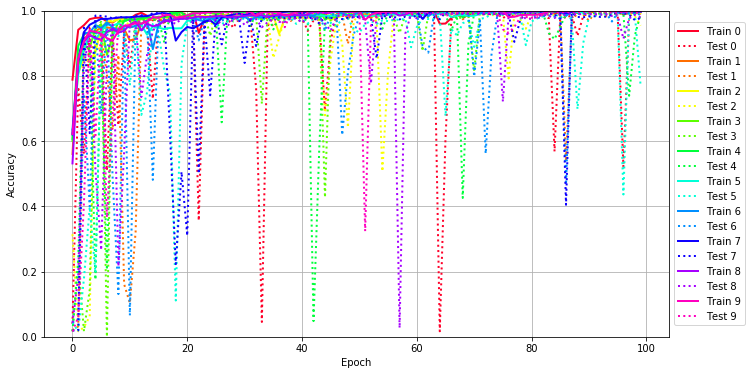

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

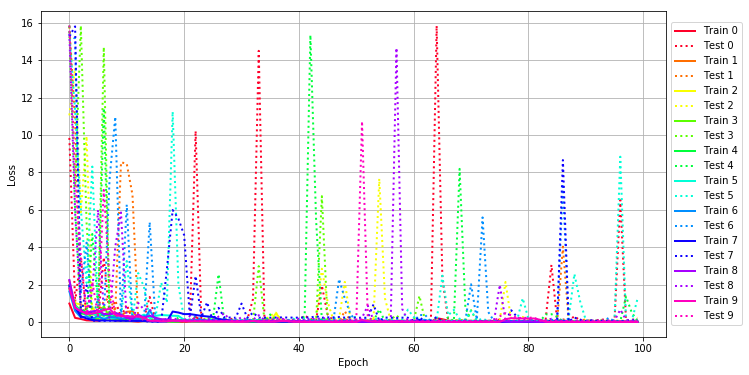

In [12]:
plot_loss(history)

Plotting the confusion matrix


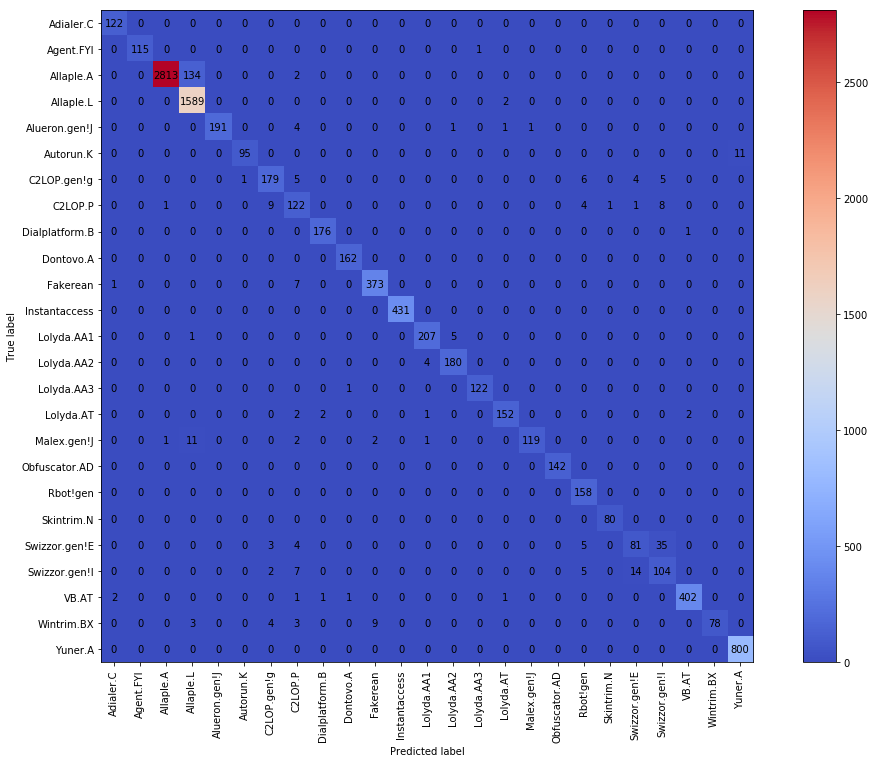

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


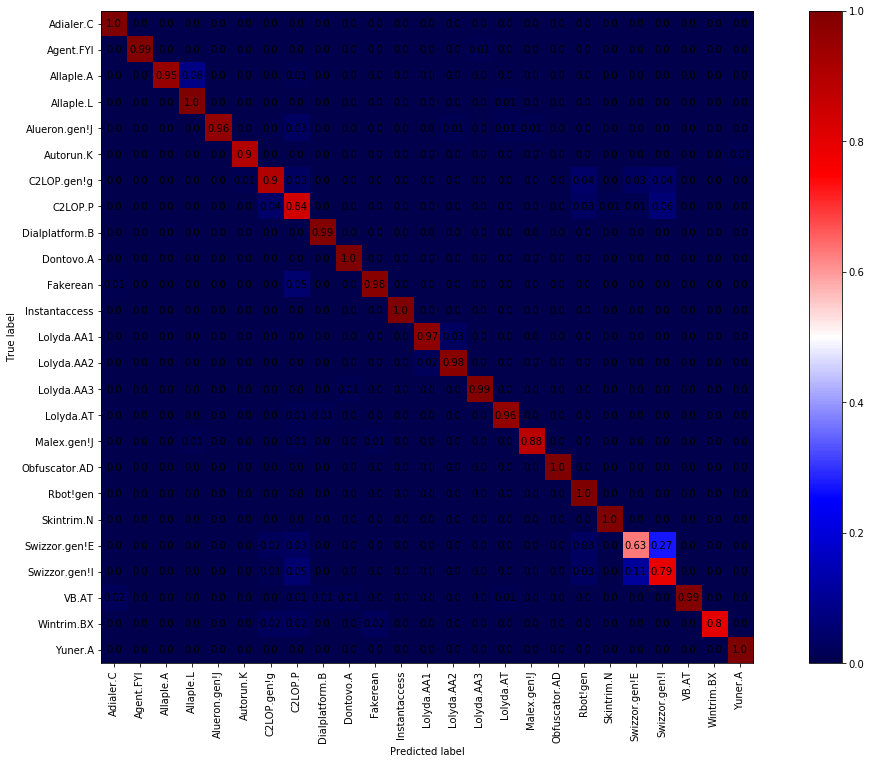

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


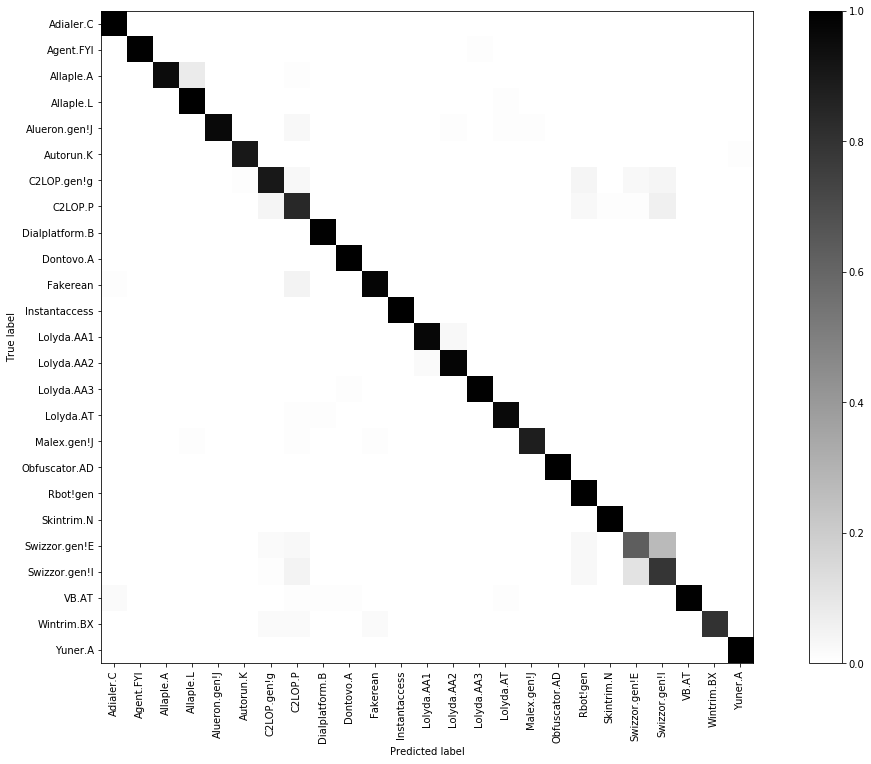

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


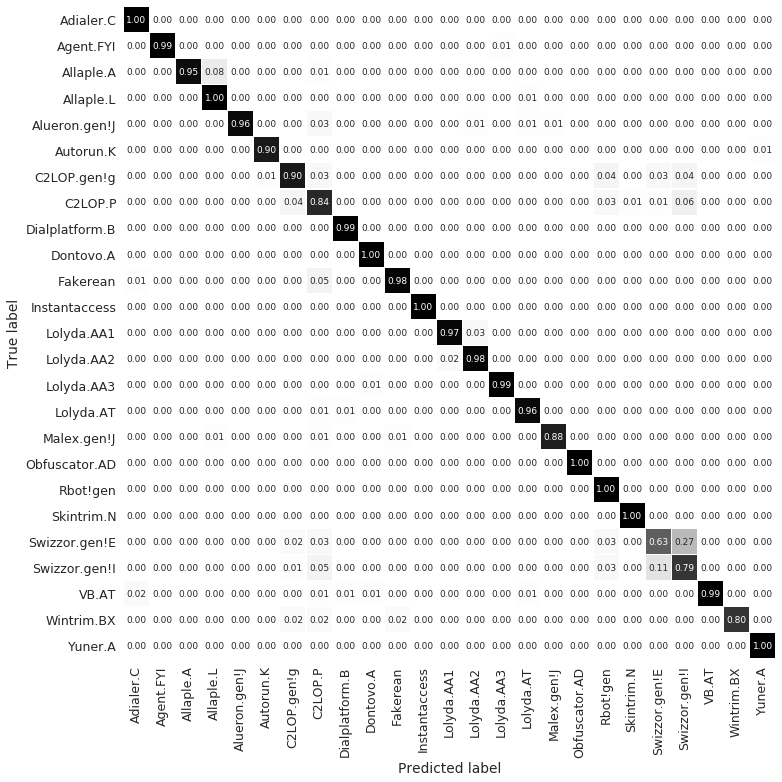

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'val_loss': [9.8429518523039636, 1.0758917540287176, 3.4519476442982162, 0.22894533936909978, 0.14322242338466581, 0.14171396514952736, 3.4505342844932798, 0.35958090082066418, 1.147137621812345, 0.26452752274143143, 0.92150964640652533, 0.1343826932720957, 0.06512221540349028, 0.17803551250700947, 1.3372450815818628, 0.096304777458235596, 0.16112601611832225, 0.079961869757956328, 0.08847522382327172, 0.057168307202306416, 0.061703653532015984, 0.069640944362929849, 10.212470624828464, 0.14384703674291313, 0.096954723076941696, 0.09746074046779156, 0.094466895011178817, 0.088293398249327401, 0.18861497756134624, 0.087780673316503077, 0.076952494052793127, 0.10230685274806602, 1.2303906633661537, 14.499107070196242, 0.15773205308135224, 0.076929431616528224, 0.086792182368689852, 0.080464590431859953, 0.090446842954449089, 0.092746215488885009, 0.099566754378497657, 0.3425678878611757, 0.1581152926972863, 0.10623345007609392, 1.9464626636582787, 0.39963648551976477, 0.0690313817305544

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

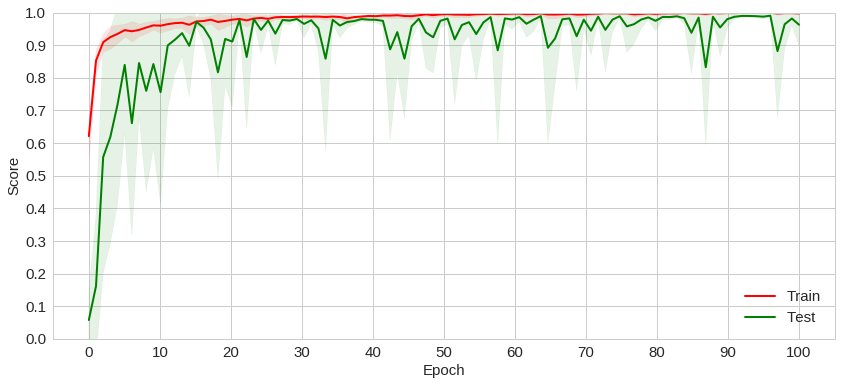

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

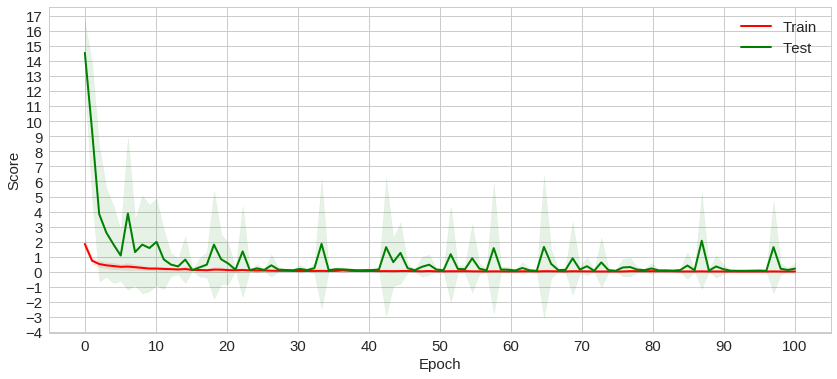

In [21]:
plot_mean_loss(history)

In [31]:
history = [{'val_loss': [9.8429518523039636, 1.0758917540287176, 3.4519476442982162, 0.22894533936909978, 0.14322242338466581, 0.14171396514952736, 3.4505342844932798, 0.35958090082066418, 1.147137621812345, 0.26452752274143143, 0.92150964640652533, 0.1343826932720957, 0.06512221540349028, 0.17803551250700947, 1.3372450815818628, 0.096304777458235596, 0.16112601611832225, 0.079961869757956328, 0.08847522382327172, 0.057168307202306416, 0.061703653532015984, 0.069640944362929849, 10.212470624828464, 0.14384703674291313, 0.096954723076941696, 0.09746074046779156, 0.094466895011178817, 0.088293398249327401, 0.18861497756134624, 0.087780673316503077, 0.076952494052793127, 0.10230685274806602, 1.2303906633661537, 14.499107070196242, 0.15773205308135224, 0.076929431616528224, 0.086792182368689852, 0.080464590431859953, 0.090446842954449089, 0.092746215488885009, 0.099566754378497657, 0.3425678878611757, 0.1581152926972863, 0.10623345007609392, 1.9464626636582787, 0.39963648551976477, 0.069031381730554453, 0.059200082305707079, 0.068650937631815234, 0.063400906459884943, 0.061782885211340767, 0.062310344806629621, 0.057818430191073467, 0.058716410605188805, 0.061987371074358408, 0.063062028432708972, 0.066015505508877775, 0.065883882603501753, 0.06592325692034369, 0.06578253026570309, 0.066708248204551124, 0.066827094389194555, 0.069634407622140349, 0.065776711694213799, 15.845196428248491, 2.3244163650368885, 0.10594441272346966, 0.050608140578254489, 0.090276998242820067, 0.065880559092784577, 0.05976523625986422, 0.054101842210838712, 0.05329469886984, 0.067360323746385689, 0.059997510507080867, 0.13288809596311435, 0.052706575813052943, 0.072773074775211777, 0.056199717327834429, 0.057871148641021691, 0.062691414221650532, 0.058507611403610861, 0.076539480597440313, 0.1485986027236558, 3.0508753854761679, 0.080158121103522717, 0.13701247820249085, 0.058017386376276486, 0.30780132725014397, 0.081227854220926488, 0.052113834400265346, 0.06051795369253269, 0.10046196360686042, 0.12922283439459836, 0.070241304175011163, 0.071498716997688769, 6.5116923256525956, 0.090433368798353495, 0.056425807984620914, 0.066434204737267202], 'loss': [0.98507900557717964, 0.21962161843254646, 0.16056762107226119, 0.087094286126070203, 0.076070533168438023, 0.067278671025349346, 0.12278348715185466, 0.13518701876742883, 0.079252765672616451, 0.072681441035033809, 0.086817213262025017, 0.043089302584119735, 0.020905537502182221, 0.060636504737880861, 0.10162861765048775, 0.062898127829457626, 0.069307878683371099, 0.040811406113161849, 0.015416222059629255, 0.0090830792214815527, 0.001944963554540632, 0.00072064380947441001, 0.26961859308000347, 0.076702865179249125, 0.053487256535124553, 0.048748022969878728, 0.045196554019315549, 0.044818624806378903, 0.041706381039460956, 0.058910897219088036, 0.040569844695856831, 0.036739862884563691, 0.046649164013379964, 0.077333832671788158, 0.071944488243976326, 0.050720531527098996, 0.0405177844700279, 0.038598252616135711, 0.040598000598370619, 0.038118051937081177, 0.037743830659278298, 0.045748038726024662, 0.049082836580469635, 0.044701361654147467, 0.043240911206303474, 0.064898827910726847, 0.03868779835554937, 0.0029305697897176919, 0.00082008291355460628, 0.00055220098162483988, 0.00022656127134176477, 0.0001732159468925285, 0.00013970880018013393, 7.9406324790197983e-05, 5.5539086842911949e-05, 5.3546132800769092e-05, 5.1356395099493806e-05, 3.8536215372065056e-05, 2.8605311494827817e-05, 2.1995002994905094e-05, 2.8767953726615384e-05, 2.0332976495291797e-05, 2.0608924673100621e-05, 2.9318444492518577e-05, 0.20307226266345982, 0.1463838406004791, 0.070885895826641454, 0.031570012745759671, 0.062408929017246165, 0.044730922568936501, 0.011478024978463156, 0.012663739670225244, 0.004549624065345201, 0.010451330856979515, 0.0042788509541000991, 0.0088736424772350667, 0.0087563383546609939, 0.0095602595806313223, 0.006095522251155441, 0.00092442534632588278, 0.0011673655386166334, 0.00075118420641364595, 0.005488457164226984, 0.0027462411786789188, 0.040095556067817194, 0.008726476067896824, 0.0057446143981792729, 0.0015471906478660771, 0.029092065685877046, 0.0050773561774610015, 0.0011915145142842184, 0.0013951071899204297, 0.0016728914896639423, 0.00064697778152573125, 0.00038420866467426461, 0.0002545700729131991, 0.044757437772292415, 0.020253147310023686, 0.004348729451404197, 0.0049748863798093736], 'val_acc': [0.039153439153439155, 0.76613756613756612, 0.56084656084656082, 0.94814814814814818, 0.94920634920634916, 0.95449735449735451, 0.51005291005291009, 0.93439153439153444, 0.64867724867724863, 0.9375661375661376, 0.82751322751322753, 0.95767195767195767, 0.98624338624338626, 0.95767195767195767, 0.73015873015873012, 0.97883597883597884, 0.95978835978835975, 0.98518518518518516, 0.98518518518518516, 0.99047619047619051, 0.98941798941798942, 0.98624338624338626, 0.35661375661375661, 0.96296296296296291, 0.97354497354497349, 0.97566137566137567, 0.97777777777777775, 0.97777777777777775, 0.94708994708994709, 0.97460317460317458, 0.97989417989417993, 0.97460317460317458, 0.76190476190476186, 0.045502645502645503, 0.95238095238095233, 0.97989417989417993, 0.97883597883597884, 0.97989417989417993, 0.97883597883597884, 0.97777777777777775, 0.97883597883597884, 0.9375661375661376, 0.97037037037037033, 0.97354497354497349, 0.69206349206349205, 0.90899470899470902, 0.98412698412698407, 0.98730158730158735, 0.98624338624338626, 0.98941798941798942, 0.98941798941798942, 0.98941798941798942, 0.98941798941798942, 0.98835978835978833, 0.99047619047619051, 0.98835978835978833, 0.98941798941798942, 0.98941798941798942, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.98941798941798942, 0.99047619047619051, 0.98941798941798942, 0.016931216931216932, 0.60952380952380958, 0.97037037037037033, 0.98835978835978833, 0.97777777777777775, 0.98518518518518516, 0.99047619047619051, 0.98835978835978833, 0.99153439153439149, 0.98835978835978833, 0.99047619047619051, 0.97671957671957677, 0.99047619047619051, 0.98412698412698407, 0.99153439153439149, 0.99153439153439149, 0.99259259259259258, 0.99153439153439149, 0.98624338624338626, 0.97671957671957677, 0.56825396825396823, 0.98730158730158735, 0.97671957671957677, 0.98730158730158735, 0.92275132275132277, 0.98412698412698407, 0.99047619047619051, 0.98730158730158735, 0.98835978835978833, 0.98412698412698407, 0.98941798941798942, 0.99047619047619051, 0.52063492063492067, 0.98306878306878309, 0.99259259259259258, 0.98941798941798942], 'acc': [0.7883011675147974, 0.94114843941825554, 0.95544436502263519, 0.97402906838217773, 0.97784131522516082, 0.97855611147981669, 0.96664284013809976, 0.96342625685013106, 0.97641172265904219, 0.97748391714043803, 0.97486299735067683, 0.98725279961877532, 0.99344770073862287, 0.98427448174429133, 0.96997855611150818, 0.98081963307124131, 0.98046223492971174, 0.98665713604955918, 0.99475816059089828, 0.99678341672623305, 0.99952346914462709, 0.99976173454391015, 0.93161782222558753, 0.97653085537288542, 0.98320228734810577, 0.98487014534191086, 0.98510841076959732, 0.98534667619728378, 0.98677626873499902, 0.98177269478198714, 0.98784846318799147, 0.9884441267572075, 0.98641887062187272, 0.97796044791060055, 0.97676912080057188, 0.98439361448653795, 0.98772933047414824, 0.98796759590183469, 0.98689540147724564, 0.98808672861567781, 0.98832499404336427, 0.98546580891112701, 0.9841553490588516, 0.98582320705265669, 0.98653800333571595, 0.97974743864665237, 0.98761019776030501, 0.99928520371694063, 1.0, 0.99988086728615677, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95961401006395486, 0.96044793897564706, 0.97712651894210145, 0.98856325948525248, 0.98213009292351683, 0.98439361448653795, 0.99606862044317368, 0.99559208958780077, 0.99880867286156783, 0.99654515129854659, 0.99892780557541105, 0.99761734573733729, 0.99690254944007628, 0.99666428401238982, 0.99904693830345592, 0.99976173457231354, 0.99940433643078386, 1.0, 0.99809387657850845, 0.99892780557541105, 0.98999285203716936, 0.99690254944007628, 0.99821300929235168, 0.9995234691162237, 0.99237550631403382, 0.99833214200619491, 0.99988086728615677, 0.99964260185847031, 0.9991660710030974, 0.99976173457231354, 1.0, 1.0, 0.98796759590183469, 0.99261377174172027, 0.99857040743388137, 0.99845127469163464]}, 
{'val_loss': [15.792995849738961, 10.763037729162066, 0.42129271409045232, 0.80601207210411441, 0.43841259180708547, 0.39266905821306186, 1.1109868568109227, 1.2916203964660546, 0.56483936957587866, 8.5399486173236951, 8.4647613533489778, 6.7981073831043934, 0.098097663511168179, 0.079836918019112232, 0.07183056326025343, 0.071271805686169531, 0.08011075869176712, 0.060167303408771196, 0.063617688714863216, 0.062336807637010758, 0.059370140399149375, 0.057540180919221813, 0.07037614632914066, 0.067145189339861786, 0.053868617102710514, 0.059301476253865663, 0.075551706833616977, 0.082579974344868176, 0.068292663778768734, 0.056423013679212632, 0.052027341531078734, 0.063254645809314031, 0.030280910969307476, 0.023185689120683566, 0.03383104471145465, 0.17660579351954409, 0.084184596584097687, 0.064874752018651963, 0.094226901001602997, 0.061062569700818185, 0.099795635226356275, 0.04239222391377151, 0.036992404028848028, 0.026626419944058653, 0.03403565413404426, 0.047617816935170289, 0.04925075192169194, 0.03052777516825848, 0.58055133223721112, 0.026097165649161497, 0.018583424758781317, 0.043662473456746675, 0.046938046903968363, 0.026134049219967939, 0.032871564711276655, 0.024556848944598884, 0.022131558975813842, 0.02257919207684728, 0.02029743999576851, 0.024949026804374712, 0.023445930881978272, 0.053381811477348759, 0.024478092182489839, 0.024388659476142979, 0.022084718234367709, 0.018143949169275315, 0.017712374602391508, 0.050119841901067087, 0.069581881236771378, 0.039348278567269086, 0.024758171551146551, 0.018977088552772584, 0.020749792354968169, 0.02594380479433115, 0.043311342244435662, 0.034344385026661775, 0.017176051938066813, 0.017711262307242993, 0.032409733731666432, 0.024357887982746927, 0.021391040152019165, 0.019467777186708966, 0.023625849107201287, 0.021146066015224823, 0.022191050250160084, 0.01630874617292806, 4.0268144606891427, 0.10488925926976987, 0.01871285107564636, 0.044358110601761876, 0.15350960411038447, 0.023306510076868445, 0.023257117865572323, 0.017818449132168804, 0.0323079656510111, 0.030835093359696281, 0.018936597496602793, 0.018253715882252483, 0.018502678043489717, 0.019075355669411834], 'loss': [2.2086622719397302, 0.76359293032674913, 0.56079632305766736, 0.4412322911362116, 0.4157773000194272, 0.37976007406553569, 0.38414428484529289, 0.41431645122158733, 0.48813834117397858, 0.34512053707092594, 0.54482472662671888, 0.57414445362304578, 0.19793850993405954, 0.088685332358813332, 0.0813284576297644, 0.071918225890329174, 0.13598101188508446, 0.070711996694686252, 0.069677000157504027, 0.081539034184187786, 0.062621668438989808, 0.062386089816558174, 0.060426636219354728, 0.056874680688754002, 0.064040478491507721, 0.065034295433101408, 0.051538679859795836, 0.059194012493253595, 0.089749391673504778, 0.062004581900058177, 0.053401297417943909, 0.050936416375348861, 0.040293304299554383, 0.01489951899337294, 0.022391134125933743, 0.075065991504197044, 0.057616014040210668, 0.052677286630217993, 0.051333129762666234, 0.049051049575966031, 0.059879827835850309, 0.037035339670360871, 0.014436040557262119, 0.013909308880663378, 0.017668971140065187, 0.02282546510455432, 0.013178924403242755, 0.013771707733504796, 0.15771318305932838, 0.025551336895275407, 0.010958558408474924, 0.021896173386729528, 0.096645069993456525, 0.024747050149465859, 0.015988900709224714, 0.030623471670494246, 0.011607123583770832, 0.0085358649115414766, 0.0078030614217087331, 0.0071865589922603798, 0.0074359307240804452, 0.0097343834357788012, 0.0072557126984160031, 0.0061582907202832682, 0.0060011636611312239, 0.0062028069522562365, 0.0063412306615573009, 0.0078438079968977184, 0.019344824216146056, 0.04500534164085869, 0.015118258904069671, 0.0096064186348904287, 0.0072275594348447589, 0.018071038990356499, 0.047153023414358598, 0.011453082850850086, 0.012607928775785504, 0.011619455055621489, 0.0049796272387669979, 0.0065583603931812602, 0.0042820983433444265, 0.0044440986951397839, 0.0043593740906193081, 0.0069920857154666966, 0.0054218730130450397, 0.0048172314469810962, 0.014228952950527351, 0.0087041354906580888, 0.0084465860485950107, 0.0082694121015180391, 0.033857133508939062, 0.0075062704931936177, 0.0049077685808817974, 0.0042149075823244312, 0.0079319931480959973, 0.0045897287229119963, 0.0040444160818429312, 0.0040148798364698628, 0.0038946706138604085, 0.003886503684980966], 'val_acc': [0.020169851380042462, 0.031847133757961783, 0.92781316348195331, 0.86305732484076436, 0.91825902335456477, 0.92675159235668791, 0.80467091295116777, 0.63481953290870485, 0.86411889596602975, 0.16135881104033969, 0.1029723991507431, 0.321656050955414, 0.96072186836518048, 0.97027600849256901, 0.97239915074309979, 0.9713375796178344, 0.96921443736730362, 0.97770700636942676, 0.97770700636942676, 0.97770700636942676, 0.97770700636942676, 0.98195329087048833, 0.97558386411889597, 0.97876857749469215, 0.97876857749469215, 0.97876857749469215, 0.97452229299363058, 0.96921443736730362, 0.97770700636942676, 0.97983014861995754, 0.98195329087048833, 0.97770700636942676, 0.9861995753715499, 0.99044585987261147, 0.9861995753715499, 0.95010615711252655, 0.97239915074309979, 0.98301486199575372, 0.96815286624203822, 0.97983014861995754, 0.96178343949044587, 0.98407643312101911, 0.98832271762208068, 0.98938428874734607, 0.98726114649681529, 0.9851380042462845, 0.98938428874734607, 0.98938428874734607, 0.89808917197452232, 0.99363057324840764, 0.99469214437367304, 0.9861995753715499, 0.9851380042462845, 0.99469214437367304, 0.99044585987261147, 0.99363057324840764, 0.99150743099787686, 0.99256900212314225, 0.99363057324840764, 0.99469214437367304, 0.99469214437367304, 0.97876857749469215, 0.99575371549893843, 0.99681528662420382, 0.99469214437367304, 0.99469214437367304, 0.99575371549893843, 0.99150743099787686, 0.97346072186836519, 0.9851380042462845, 0.99363057324840764, 0.99363057324840764, 0.99469214437367304, 0.99469214437367304, 0.98726114649681529, 0.98938428874734607, 0.99469214437367304, 0.99575371549893843, 0.9861995753715499, 0.99363057324840764, 0.99469214437367304, 0.99469214437367304, 0.99363057324840764, 0.99575371549893843, 0.99469214437367304, 0.99681528662420382, 0.53821656050955413, 0.96815286624203822, 0.99256900212314225, 0.98726114649681529, 0.96921443736730362, 0.99256900212314225, 0.99044585987261147, 0.99363057324840764, 0.99044585987261147, 0.99150743099787686, 0.99575371549893843, 0.99575371549893843, 0.99575371549893843, 0.99469214437367304], 'acc': [0.56055734192202089, 0.85816362989620321, 0.91068238666600754, 0.93330951540955931, 0.93652494950025889, 0.94795760390615691, 0.94843396461760987, 0.94617125173686611, 0.93997856388634926, 0.94438489948239546, 0.90806240335282529, 0.91389782074960879, 0.95950934867624926, 0.971061093346965, 0.97403834712807724, 0.97761105158023209, 0.96343932366731755, 0.97892104322972495, 0.97832559257997731, 0.97713469096105754, 0.98106466605150233, 0.98118375610337027, 0.98035012504465879, 0.98308919862265864, 0.98118375621694343, 0.98082648564963681, 0.98523282124568301, 0.98416100992707256, 0.97344289637185488, 0.98154102655710374, 0.98511373109443845, 0.9845182804375926, 0.98821007512617187, 0.99714183637013221, 0.99487912351068353, 0.9790401333809694, 0.98320828877390321, 0.98428010003572708, 0.98582827210128199, 0.9865428129093724, 0.98249374776705967, 0.98952006669048465, 0.99726092652137666, 0.99666547576515419, 0.99630820531142072, 0.99547457425270935, 0.99761819697511012, 0.9972609265355733, 0.97499106823865667, 0.99380731213528639, 0.99749910693034061, 0.99487912359586339, 0.97713469106753237, 0.99333095153030848, 0.99523639405669517, 0.992497320471597, 0.99785637727759913, 0.99904727888942058, 0.99916636894128852, 0.99928545909253308, 0.99916636894128852, 0.99833273788257715, 0.99928545909253308, 0.99964272954626654, 0.99964272954626654, 0.99964272954626654, 0.99964272954626654, 0.99892818863879962, 0.99595093495706388, 0.98975824699297366, 0.99678456591639875, 0.99857091818506605, 0.99940454934315415, 0.99535548421503806, 0.98713826366559487, 0.99738001668681786, 0.99749910692324228, 0.99726092652137666, 0.99952363939502198, 0.99916636894128852, 0.99976181979688761, 0.99964272954626654, 0.99964272954626654, 0.99892818863879962, 0.99916636894128852, 0.99952363939502198, 0.99642729546266529, 0.9984518280338216, 0.99773728712635468, 0.99833273788257715, 0.99166368941288552, 0.99821364773133259, 0.99952363939502198, 0.99964272964564305, 0.99821364773133259, 0.99952363939502198, 0.99976181969751099, 0.99976181969751099, 0.99976181969751099, 0.99976181969751099]}, 
{'val_loss': [11.048971611299498, 13.571588365762219, 5.8723218026700055, 9.9344370657447048, 0.33294519468700623, 1.0900617438688207, 0.19471127265043606, 0.11447820008743487, 0.096730533570025382, 0.08350892282551034, 0.1858039216882556, 0.091919782862905211, 0.081560489085717877, 0.19837808978231058, 0.08010382492813814, 0.082866304891314538, 0.08664886429485158, 0.082041011981989764, 0.082955210498937629, 0.083800247769654751, 0.075296349873553325, 0.083516655359905573, 0.077535452780131103, 0.078314112598970184, 0.1691886969221687, 0.22160152050891949, 0.086375742296433744, 0.080842907800988947, 0.09099940710453755, 0.099805032439618219, 0.092624646309480932, 0.08661370739265839, 0.091137426181416931, 0.11231031552517906, 0.085662349227981383, 0.32804320751560623, 0.49733325204721984, 0.077561542815791612, 0.073101945311412689, 0.083348034569521418, 0.075695552411911282, 0.080544461090179972, 0.081938083239436466, 0.083249390062347897, 2.8442547760093664, 1.0784024222406621, 0.10924434709128319, 0.17988726230438118, 2.145439490708196, 0.10663239530156149, 0.050047297780625832, 0.056580729702682513, 0.062677411590158452, 0.15067081179141673, 7.6632610007259601, 1.2579725096360279, 0.061005821779386571, 0.066056523143200124, 0.078125966217734752, 0.058471118701328338, 0.046479936050596533, 0.049234360111571354, 0.051792572244671251, 0.05648993258976711, 0.057035319790693373, 0.059238191401279318, 0.074439065418334102, 0.058524510768987043, 0.067574764075711585, 0.064809551932738879, 0.066009289127975629, 0.075742792040611739, 0.063895517894088538, 0.069069651814038915, 0.076030455061893418, 0.083656608886753248, 2.1446555117514436, 0.060163247851243933, 0.10832888540998475, 0.26903610151271629, 0.062761321275169688, 0.069739724532272701, 0.082238150915729225, 0.088590163376210104, 0.075743445402411083, 0.068968201755403011, 0.080641359197586332, 0.073111709902992914, 0.069142380835689757, 0.072306976742044587, 0.08747164893957679, 0.076557324562459519, 0.075507435475780871, 0.11592153557468651, 0.076720003995976685, 0.078027316581420786, 0.079094083252891217, 0.079771450481201642, 0.10652049719795001, 0.22946748165864256], 'loss': [1.9775533940221366, 1.0099773058052957, 0.92358312050851521, 0.83402168403110566, 0.81201841957213527, 0.2708095209809403, 0.13018274957857562, 0.12306528159684048, 0.10678797110816741, 0.1009682633207552, 0.091338685878998474, 0.077590365993800633, 0.071951926793956775, 0.10554434548863455, 0.081106168457078881, 0.069014028238868472, 0.062356514364450819, 0.056456414130174354, 0.06132133641861022, 0.055921293871989193, 0.055390204184680533, 0.0562689412532002, 0.049971850152356813, 0.0516437683314344, 0.05236363641762725, 0.057784326927936613, 0.053525246563603121, 0.046613097447161869, 0.049346596480434463, 0.046222481395485654, 0.057124155889050288, 0.051296039200865139, 0.041294730221636489, 0.044374200269010518, 0.046582785141079511, 0.045479523553449246, 0.4618319275515918, 0.070603407466217183, 0.06090784844007964, 0.057870540643303103, 0.051776036219275602, 0.049508006524690604, 0.044591502357775821, 0.047574232297487987, 0.056849005700945643, 0.11647017926479675, 0.08616397050133405, 0.058106629605176777, 0.035960569634098848, 0.020854569752504961, 0.0089836995319378284, 0.0058344237889073293, 0.0099292636281723013, 0.15594753918579762, 0.025150316270859154, 0.018500766049695378, 0.0084307768556512539, 0.0090642821369875601, 0.0046158248815056282, 0.0047275010074173205, 0.0072060439788374647, 0.0025983582878205515, 0.0023772891469309196, 0.0013135162648256994, 0.0019610801918235675, 0.031875340409360499, 0.011127659489056663, 0.0052267995970356387, 0.0019627549101462289, 0.0015371718795822863, 0.00065157198506552003, 0.00062842792819166858, 0.0040168237545444487, 0.0026862463807564301, 0.0010085542470752939, 0.0006741862076135609, 0.069610231472771275, 0.020101727526910137, 0.0048889313521442998, 0.041481976551463538, 0.0066420819371928288, 0.0031229829081967065, 0.003837738313216836, 0.0081603119712285836, 0.00098230116862689856, 0.0039221567427617553, 0.002676336152411207, 0.010339551837435849, 0.0091895291412080922, 0.0054100820633651838, 0.007196438556030949, 0.0022193172647198825, 0.00051669396788322293, 0.0043562871642536362, 0.003284371116379936, 0.00023005159902388586, 0.00011820100931928151, 8.177994294564697e-05, 0.0045366524214208882, 0.02352144438323308], 'val_acc': [0.31449893390191896, 0.017057569296375266, 0.028784648187633263, 0.062899786780383798, 0.91257995735607678, 0.86567164179104472, 0.95948827292110872, 0.97441364605543712, 0.9733475479744137, 0.97867803837953093, 0.94882729211087424, 0.97761194029850751, 0.97974413646055436, 0.95842217484008529, 0.97867803837953093, 0.97867803837953093, 0.97547974413646055, 0.98187633262260132, 0.97761194029850751, 0.97761194029850751, 0.98081023454157779, 0.97867803837953093, 0.97867803837953093, 0.97867803837953093, 0.96481876332622596, 0.94882729211087424, 0.97761194029850751, 0.98187633262260132, 0.97654584221748397, 0.97867803837953093, 0.97867803837953093, 0.97867803837953093, 0.97761194029850751, 0.97547974413646055, 0.97761194029850751, 0.85501066098081024, 0.91684434968017059, 0.97761194029850751, 0.98081023454157779, 0.97867803837953093, 0.97654584221748397, 0.97867803837953093, 0.97654584221748397, 0.97228144989339016, 0.67910447761194026, 0.85287846481876328, 0.97014925373134331, 0.89765458422174838, 0.64179104477611937, 0.96801705756929635, 0.98827292110874199, 0.99040511727078895, 0.99040511727078895, 0.96481876332622596, 0.5074626865671642, 0.81556503198294239, 0.98827292110874199, 0.98720682302771856, 0.98614072494669514, 0.98933901918976541, 0.99147121535181237, 0.9925373134328358, 0.99360341151385922, 0.9925373134328358, 0.99040511727078895, 0.98827292110874199, 0.98720682302771856, 0.99147121535181237, 0.98933901918976541, 0.99040511727078895, 0.99040511727078895, 0.98827292110874199, 0.98720682302771856, 0.98614072494669514, 0.98614072494669514, 0.98827292110874199, 0.79211087420042647, 0.99147121535181237, 0.9733475479744137, 0.94456289978678043, 0.98933901918976541, 0.98720682302771856, 0.9850746268656716, 0.98720682302771856, 0.98720682302771856, 0.98933901918976541, 0.98614072494669514, 0.99147121535181237, 0.99040511727078895, 0.98933901918976541, 0.98933901918976541, 0.98933901918976541, 0.99040511727078895, 0.98187633262260132, 0.99040511727078895, 0.98933901918976541, 0.99040511727078895, 0.99040511727078895, 0.98294243070362475, 0.95415778251599148], 'acc': [0.62242590169256151, 0.80883228191377554, 0.85204142368261249, 0.84228068092098951, 0.87334841091765381, 0.94643494823463981, 0.96786096905997898, 0.96619450067596879, 0.97309844066182594, 0.97428877514581602, 0.97595524342340201, 0.97476490893941192, 0.97738364481837992, 0.97036067135574389, 0.97631234376859899, 0.97762171182869706, 0.98000238066896794, 0.98154981549815501, 0.97964528032377096, 0.98202594929175102, 0.98262111653374595, 0.98166884894655393, 0.98357338412803297, 0.98333531722414003, 0.98393048446613496, 0.98143078204975598, 0.98333531722414003, 0.98535888584692299, 0.98404951791453399, 0.98559695275791093, 0.98131174860135695, 0.98369241756933701, 0.986668253779312, 0.98500178550172601, 0.98500178550172601, 0.9854779193095119, 0.92846089751220096, 0.97643137721699802, 0.97952624687537193, 0.98047851459027302, 0.98369241769704607, 0.98428758481133194, 0.98512081895012493, 0.98500178562943497, 0.98464468528423799, 0.97095583859064394, 0.97845494596749005, 0.98404951791453399, 0.98928698964409001, 0.99321509344125702, 0.99773836448041897, 0.99809546482561595, 0.99916676588249187, 0.976788477562195, 0.99309605999285799, 0.99428639447684797, 0.99678609702093601, 0.996548029996429, 0.99904773241280798, 0.99821449840172405, 0.99738126413522199, 0.99916676586120701, 0.99940483275800496, 0.99976193310320205, 0.99952386622059386, 0.99131055826687298, 0.996548029996429, 0.99821449827401498, 0.99952386620640399, 0.99976193310320205, 1.0, 0.99988096655160097, 0.99845256517081304, 0.99916676586120701, 0.99988096655160097, 0.99988096655869596, 0.98285918344473389, 0.99523866206403999, 0.998452565298522, 0.98607308653731696, 0.997857397928818, 0.99916676586120701, 0.99880966551601003, 0.99773836448041897, 0.99988096655160097, 0.99892869896440895, 0.99904773241280798, 0.99797643150492599, 0.99797643138431191, 0.99869063206761099, 0.997857397928818, 0.99976193310320205, 1.0, 0.99928579930960604, 0.99952386620640399, 1.0, 1.0, 1.0, 0.99892869897150394, 0.99250089275086295]}, 
{'val_loss': [15.842572399693676, 7.2232174669575491, 15.842572399693676, 5.296515974224123, 0.13535727958521274, 0.11461706805584204, 14.695011823605268, 0.23307751611799984, 0.16554953367250341, 0.096975451543266505, 0.076488429331966937, 0.20926899356473402, 0.072133813881557735, 0.068110895533003257, 0.059765743215515199, 0.060855032549326039, 0.073732003925776057, 0.076267539757093564, 0.024591331633290924, 0.039989564860252555, 0.02767394743043438, 0.034491461789871329, 0.023787262886235422, 0.032604084326755045, 0.26976893920003092, 0.059780440857989406, 0.031535616150756694, 0.031302214444676638, 0.035424617171385689, 0.029424187531078179, 0.026322143708192476, 0.033672539172468346, 0.037176057834277638, 2.9826568148984967, 0.063272174954564581, 0.0773969175105889, 0.058712004302658619, 0.060067740997285124, 0.028622126599517426, 0.083351814064682797, 0.06413897122919747, 0.034820172082707622, 0.022362504435532018, 0.031552018347436109, 6.72820096341973, 0.055912066048646812, 0.035351144950054654, 0.03402723435040874, 0.030215355251406877, 0.027973010117193553, 0.027927409479745705, 0.026583530468318961, 0.042180430397941088, 0.019089356833843208, 0.024466641031680465, 0.049936711708770634, 0.13853806537872904, 0.35396406024795934, 0.045619537937735696, 0.0390446419700647, 0.030979701506887582, 1.3945563777493759, 0.050953048263337165, 0.019915906637935323, 0.021081347584526094, 0.025157258698924032, 0.032874959588193281, 0.077736336559031088, 0.083688635163908606, 0.075014628744210096, 0.62971917437903557, 0.020645603336063679, 0.028615517160345855, 0.032486223961063258, 0.031635505078084804, 0.034030621837559026, 0.034216058035089481, 0.034824830203493765, 0.034475382536142102, 0.035495593210454826, 0.036642382257283258, 0.037147039116419353, 0.038163259475458615, 0.041740519224879237, 0.039593457298251374, 0.039356991512809497, 0.041259572561157101, 0.042510019540247579, 0.04018309707101575, 0.041488779293247825, 0.046209297363944669, 0.046250837418913053, 0.04735146413731349, 0.042348511573216951, 0.045735613554380217, 0.049180944919873938, 0.05078461991425124, 0.049172403075229139, 0.049408238382801187, 0.047319056200374368], 'loss': [1.7719290297357408, 0.91018964356784804, 0.61652775077781241, 0.55113892235047157, 0.19322184835564277, 0.14597593230866654, 0.84772742072641882, 0.25270049152141039, 0.11081854281094718, 0.10040118594547616, 0.086125794078613427, 0.10412374910933198, 0.081647091158249543, 0.067445483790626551, 0.06767517675388629, 0.064051361335369428, 0.058007845058585014, 0.053830019353966398, 0.030070955245962868, 0.05283003829142089, 0.056416568145715384, 0.017224760661479103, 0.010460605722136408, 0.012832022529884066, 0.019767523306866042, 0.03586453354152614, 0.018702612166614046, 0.0088056072875191023, 0.0049422799230998864, 0.011730724579197894, 0.011015657128651579, 0.0080163040162143599, 0.0066490205368569333, 0.1192294341784339, 0.055394597618434877, 0.069286747121706641, 0.048575323883244127, 0.053620450630009094, 0.023085126320952255, 0.013362650080560382, 0.014320632285949082, 0.004962638157755086, 0.00168635885963077, 0.00099033166642890089, 0.095500008536500064, 0.064537298200734242, 0.061743647418716727, 0.016490157844619449, 0.0094289468845398412, 0.005863088147569433, 0.0047806531250887806, 0.0021699325749409675, 0.001767195496924499, 0.0045476445204925353, 0.0038249524114390798, 0.0045125430433661917, 0.0045408918405370419, 0.02247028323070711, 0.016334242234322397, 0.0034331519149947507, 0.0041208161119498888, 0.0030157492720452937, 0.0077275453226059616, 0.012518637545476255, 0.0030984984026202365, 0.00049108058269963905, 0.00042333751260481957, 0.0033899400080648393, 0.0069077897082882806, 0.017099890230680388, 0.03490115866255878, 0.0084606119587286571, 0.0011906073770143514, 0.0005550722740689767, 0.00034409247132492402, 0.00019335119259121113, 0.00019561842024088535, 0.00015409404878777901, 0.00010252414124370743, 7.1086164766689404e-05, 5.9841004898369876e-05, 5.3261080389348922e-05, 3.686354026875793e-05, 4.9115657530810608e-05, 4.0022643316065218e-05, 3.650824678347769e-05, 3.1607519628251178e-05, 2.9880053543503268e-05, 2.6784308214639103e-05, 6.4012789787815574e-05, 3.597709569506984e-05, 1.580463985983701e-05, 2.8309823022895708e-05, 4.1265434113337927e-05, 1.5774429802683747e-05, 1.2747373684866603e-05, 1.2640412510866126e-05, 8.0289001201369821e-06, 8.9606751938558232e-06, 9.3663942110223169e-06], 'val_acc': [0.017094017094017096, 0.23076923076923078, 0.017094017094017096, 0.14423076923076922, 0.94871794871794868, 0.96581196581196582, 0.0, 0.94017094017094016, 0.94444444444444442, 0.97008547008547008, 0.97222222222222221, 0.92521367521367526, 0.97115384615384615, 0.9786324786324786, 0.97970085470085466, 0.9786324786324786, 0.9786324786324786, 0.97329059829059827, 0.99038461538461542, 0.99038461538461542, 0.98717948717948723, 0.98931623931623935, 0.99252136752136755, 0.99252136752136755, 0.92307692307692313, 0.98611111111111116, 0.99038461538461542, 0.99145299145299148, 0.99252136752136755, 0.99038461538461542, 0.98824786324786329, 0.99038461538461542, 0.98931623931623935, 0.71474358974358976, 0.9850427350427351, 0.97115384615384615, 0.97756410256410253, 0.98076923076923073, 0.99145299145299148, 0.9754273504273504, 0.98824786324786329, 0.99145299145299148, 0.99252136752136755, 0.99145299145299148, 0.42735042735042733, 0.98611111111111116, 0.98183760683760679, 0.99038461538461542, 0.99038461538461542, 0.98931623931623935, 0.99252136752136755, 0.99465811965811968, 0.99145299145299148, 0.99465811965811968, 0.99358974358974361, 0.99145299145299148, 0.9786324786324786, 0.93162393162393164, 0.98717948717948723, 0.98824786324786329, 0.99252136752136755, 0.87606837606837606, 0.98931623931623935, 0.99145299145299148, 0.99252136752136755, 0.99358974358974361, 0.99145299145299148, 0.9754273504273504, 0.97970085470085466, 0.98611111111111116, 0.81517094017094016, 0.99252136752136755, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99465811965811968, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99465811965811968, 0.99465811965811968, 0.99465811965811968, 0.99465811965811968, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99358974358974361, 0.99465811965811968, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99465811965811968, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968], 'acc': [0.60061882653861165, 0.82898964665410746, 0.88956325131910807, 0.88694513871898739, 0.9447816256099012, 0.95846721409020585, 0.86445317150056045, 0.92133761761685884, 0.96513150065452813, 0.96905866957244224, 0.97262882308904353, 0.96798762346780909, 0.97358086397715105, 0.97857907895004548, 0.97727002261097229, 0.98131619664610648, 0.97976913012224598, 0.98155420683089378, 0.98928953945019638, 0.98322027852162708, 0.98464833987861478, 0.99476377484231826, 0.99654885160061879, 0.99476377484231826, 0.99309770320123769, 0.98964655480185648, 0.99369272878733783, 0.99702487206949897, 0.99880994887745245, 0.99583482089729858, 0.99595382601451865, 0.99714387718671904, 0.9984529334761395, 0.97036772581220998, 0.98238724265143396, 0.97941211477058576, 0.98488635016270765, 0.98333928358919431, 0.99202665714625726, 0.99523979531119833, 0.99452576460787812, 0.99797691300725933, 0.99964298464833989, 0.99976198976555997, 0.97274782820626349, 0.9807211710103535, 0.97893609425205286, 0.99464476972509819, 0.99702487206949897, 0.9980959181244794, 0.99821492324169936, 0.99952397953111982, 0.99952397953111982, 0.99857193859335946, 0.99869094371057954, 0.99892895394501968, 0.99869094371057954, 0.99357372367011787, 0.99464476972509819, 0.99857193859335946, 0.9984529334761395, 0.99892895394501968, 0.99773890282247202, 0.99607283113173861, 0.99892895394501968, 1.0, 1.0, 0.99869094371057954, 0.99761989765559922, 0.99523979531119833, 0.99083660597405687, 0.99750089253837915, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 
{'val_loss': [15.84065242502141, 6.0700515397729724, 0.6735928584408154, 0.5724865603972884, 4.7071201895647512, 0.78979570468399618, 11.432405350094207, 0.46516423742237056, 0.089385544988323226, 0.07243705586887296, 0.14455422697565884, 0.19283660694877094, 0.15784374268234369, 0.11113426167420862, 0.13766494727503856, 0.14236570557475686, 0.10719611072953043, 0.056554468196243539, 0.037020056955816713, 0.22926333700207691, 0.089797250236095708, 0.091482472052890437, 0.030250156352708401, 0.049689031402008636, 0.08265636785727111, 0.095900470696583903, 2.552015526052116, 0.029751663103735167, 0.12506612848451878, 0.072122137459446872, 0.062169117904644453, 0.15482151343206749, 0.034985047572071659, 0.032039149165917907, 0.027701827693529978, 0.40302272853094662, 0.1006150043509712, 0.073928247051693888, 0.069526910891001659, 0.036945523876702427, 0.064699804131824856, 0.30786402128804302, 15.342358210762555, 5.4125636166454054, 0.08362996287499247, 0.025097172732843474, 0.031520767363643849, 0.03989399903128453, 0.026568098424974006, 0.040449032812830653, 0.052398398081788158, 0.0337483584204087, 0.027973695147148953, 0.035307615828371712, 0.67226349708056909, 0.027015636139132018, 0.02572700585262409, 0.028513451075938105, 0.030392219098230564, 0.030016787168110542, 0.034011523311936007, 0.030196261165907286, 0.039859779451194663, 0.028118730495226191, 0.026616104088929022, 0.061703767157860301, 0.24514278023490335, 0.040694518464565614, 8.1866264348597451, 0.792604542268879, 0.033617408476508029, 0.025666838403736757, 0.022395332733870121, 0.032245765552447736, 0.029537232372601762, 0.029159567065479276, 0.028918369802127721, 0.025557866620315534, 0.023572401249373525, 0.025372500489265318, 0.029087938950012361, 0.026826754797176767, 0.029051230844134822, 0.40621898346480956, 0.4165347417176547, 0.27725395185762097, 0.037908144776696268, 0.021811778558789383, 0.034325715038817012, 0.024342970340739338, 0.025296067659853767, 0.028087766748750465, 0.024032469638756899, 0.023579710034349541, 0.024177514590746067, 0.024796754078438597, 0.026566753641822274, 1.3617539473077271, 0.50377836318828895, 0.049196222524442612], 'loss': [1.9088322561959434, 0.63322605943747901, 0.46331523612021036, 0.3984421827519638, 0.41536633919273769, 0.45504336746348362, 0.37593865686799732, 0.31647291880230399, 0.31620041519289976, 0.11013688043053343, 0.086241986430553752, 0.094759755519204111, 0.07857258760435476, 0.069868075864824838, 0.066177321671517561, 0.061545403754921089, 0.058160512330899743, 0.028069001074165802, 0.023203875846018938, 0.018582981962600685, 0.065582077599164706, 0.036985908272139364, 0.015142573261574116, 0.011987058314712437, 0.010646486175197777, 0.020616881732320479, 0.020932455382698608, 0.0076943080341363634, 0.014514969918543986, 0.021671929561698375, 0.011312399888224434, 0.011629522873342714, 0.0083563366421628687, 0.002908021496345769, 0.002124051291268646, 0.027064296522992054, 0.015895704604593993, 0.0063792952115120883, 0.0038198602141355786, 0.0095042939032055612, 0.0087717037092427102, 0.0085302631807128333, 0.10762057385589353, 0.081598081651708024, 0.02811078395054404, 0.015934709486770064, 0.01277621253753752, 0.0078213702105358069, 0.0093879510493485169, 0.0073283491073553491, 0.034094120475715348, 0.0087449395473246806, 0.0058196535085922796, 0.0024528490331357277, 0.024851641587628009, 0.01162881069146028, 0.0036166460348748043, 0.0013439460600697243, 0.0010049944235693085, 0.001086463428582266, 0.002237665780907444, 0.0027912492882783946, 0.0080283698551059796, 0.0040293062669815704, 0.0039511354638214601, 0.0029805816535616435, 0.0023134630279761691, 0.0035862318123579965, 0.082462029481140828, 0.02013839588915424, 0.0057832455540531144, 0.0075128105642031234, 0.0029521799869451945, 0.0011258240170971441, 0.0020922341026519352, 0.00098331060294763501, 0.00029113470404490877, 0.00042025347124103203, 0.00044286445789329203, 0.00021831741351641744, 0.00031380545626011661, 0.00020482235279012492, 0.00040753067025580889, 0.0085603472551109543, 0.017419700091516332, 0.017013927136680512, 0.0087598718867137638, 0.0031333964562794566, 0.0012596791905416173, 0.0002983172309765495, 0.00032939905838859465, 0.00018024556925833225, 0.00012229227061240095, 7.5172142034737451e-05, 4.6591872700795311e-05, 8.0977938629847926e-05, 5.0928171956890903e-05, 0.005247895568960291, 0.023826576080740233, 0.005483097113257198], 'val_acc': [0.017112299465240642, 0.2320855614973262, 0.92085561497326207, 0.87914438502673797, 0.17540106951871659, 0.90481283422459891, 0.20534759358288771, 0.92941176470588238, 0.96684491978609621, 0.97540106951871652, 0.97647058823529409, 0.95080213903743316, 0.97112299465240637, 0.97112299465240637, 0.97112299465240637, 0.97219251336898393, 0.90160427807486632, 0.98716577540106953, 0.98930481283422456, 0.97754010695187166, 0.9732620320855615, 0.9732620320855615, 0.99144385026737969, 0.98930481283422456, 0.98395721925133695, 0.97967914438502679, 0.65775401069518713, 0.98930481283422456, 0.96684491978609621, 0.98288770053475938, 0.9850267379679144, 0.95294117647058818, 0.99037433155080212, 0.98716577540106953, 0.99144385026737969, 0.94224598930481285, 0.97860962566844922, 0.98395721925133695, 0.98288770053475938, 0.98930481283422456, 0.98716577540106953, 0.96256684491978606, 0.048128342245989303, 0.57647058823529407, 0.97112299465240637, 0.99144385026737969, 0.98930481283422456, 0.99037433155080212, 0.98930481283422456, 0.99144385026737969, 0.97860962566844922, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.94438502673796787, 0.99251336898395726, 0.99144385026737969, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.99144385026737969, 0.98930481283422456, 0.99572192513368984, 0.99251336898395726, 0.9882352941176471, 0.93796791443850269, 0.9850267379679144, 0.42566844919786095, 0.90053475935828875, 0.99037433155080212, 0.99465240641711228, 0.99144385026737969, 0.99465240641711228, 0.98930481283422456, 0.99358288770053471, 0.99358288770053471, 0.99358288770053471, 0.99358288770053471, 0.99251336898395726, 0.99144385026737969, 0.99358288770053471, 0.99358288770053471, 0.9315508021390374, 0.91229946524064176, 0.95080213903743316, 0.99037433155080212, 0.99251336898395726, 0.99251336898395726, 0.99144385026737969, 0.99144385026737969, 0.99251336898395726, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.73903743315508019, 0.92406417112299466, 0.98930481283422456], 'acc': [0.60685387910518795, 0.89183722034288215, 0.92812946218924541, 0.93360304622523049, 0.93122322709148464, 0.93538791054717019, 0.93419800089518834, 0.94002855788634421, 0.93824369347929559, 0.96751546882436934, 0.97382198952879584, 0.97298905280361514, 0.97715373628767033, 0.97941456449309849, 0.97739171822941462, 0.98012851023322223, 0.98096144693003329, 0.99286054259876244, 0.99286054259876244, 0.99452641599238456, 0.97989052831984769, 0.98714897667777246, 0.99512137074745133, 0.99535935268919562, 0.99571632555925749, 0.99357448831051653, 0.99416944312232269, 0.99773917182294147, 0.99631128034269401, 0.99357448833888629, 0.99631128034269401, 0.99631128034269401, 0.99690623512613041, 0.9989290813898144, 0.99964302712993813, 0.99214659685863871, 0.99500237981913375, 0.9978581627796288, 0.99881009043312707, 0.99654926225606855, 0.99678724416944309, 0.99702522602607835, 0.98060447403160178, 0.97893860063797966, 0.9915516420752023, 0.99583531651594481, 0.99619228938600668, 0.99809614469300334, 0.99773917182294147, 0.99821513570642995, 0.98988576868158018, 0.99738219895287961, 0.99821513564969067, 0.9994050451598242, 0.99357448833888629, 0.99607329842931935, 0.9989290813898144, 0.99988100904331267, 0.99988100904331267, 0.99976201808662546, 0.99904807234650161, 0.99940504521656359, 0.99726320799619228, 0.99869109947643975, 0.99881009043312707, 0.99916706330318894, 0.99952403617325081, 0.99928605425987627, 0.97917658255135431, 0.99274155164207523, 0.99762018086625415, 0.99809614469300334, 0.99904807234650161, 0.99976201808662546, 0.99916706330318894, 0.99976201808662546, 1.0, 0.99988100904331267, 0.99988100904331267, 1.0, 1.0, 1.0, 0.99988100904331267, 0.9978581627796288, 0.99571632555925749, 0.99452641599238456, 0.99762018086625415, 0.9989290813898144, 0.99964302712993813, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99857210851975253, 0.99309852451213709, 0.99797715373631601]}, 
{'val_loss': [15.411312662216432, 11.331967775069456, 6.0561649738148571, 2.0877994991161608, 8.31003948354466, 0.49850895600443218, 0.11869941706119234, 0.26054914589612721, 0.50547898176778605, 0.21223749014783033, 3.2606827325202565, 0.13680052736414258, 2.6129763625008908, 1.8787543504952109, 0.17024540988339937, 0.2384737431662024, 2.1098524388503583, 1.0361483515265153, 11.250189869926576, 1.9841473439638628, 0.1446823629307222, 0.1295998897903691, 0.11387416819162806, 0.096252131906428617, 0.10610333368232608, 0.27418786721201688, 0.1515054250117964, 0.17901789813771232, 0.10583416732593434, 0.11276014660981021, 0.097663964064291661, 0.10751159503683774, 0.10043257769282592, 0.10567771503848881, 0.11378335052319737, 0.10259519199393118, 0.095814121108448488, 0.11906670214976234, 0.096932801451529327, 0.17635807832609612, 0.095021489170183993, 0.17229914052068174, 0.11080709362875223, 0.099895526091462336, 0.20995023056854156, 0.12509252452153616, 0.21547030613030929, 0.12313723793516676, 0.11538959497197952, 0.27720612902758246, 0.24860589221381893, 0.15764007274868644, 0.13846015353267827, 0.15330741086172225, 0.14436205590918202, 0.1227701572850745, 0.11144692227313344, 0.11317885869676711, 0.11744392923174894, 0.66042478363564505, 0.26618072842138257, 0.10718505817939317, 0.11959118596947071, 0.10932447689669217, 0.07033224477106359, 2.4744997233630501, 0.35686737140192387, 0.64782460357526817, 0.16737115401351704, 0.12060162750046748, 0.61219505166732602, 0.079881986953666897, 0.17169611344958871, 0.059843862092096446, 0.09200000531378795, 0.062289451657803988, 0.059276719271981367, 0.055072780857654657, 0.073850332825687592, 1.2658048260709269, 0.16384278497892843, 0.092609320235045894, 0.1159239704872226, 0.051078355674713444, 0.04585820732997252, 0.13749887548178558, 0.063561747836597363, 0.17769143068850332, 2.568808953264818, 1.1031205383079059, 0.090958061257498307, 0.064995541513074143, 0.044894959122085638, 0.052539985690737374, 0.053821786712646001, 0.10113032282606776, 8.8393431903764519, 0.051683588667144835, 0.05925441375689687, 1.2414433600285146], 'loss': [1.8709686124738996, 0.84423354771635406, 0.58774166694996988, 0.42506490432183441, 0.47196369331998522, 0.2746430131607201, 0.19467969511816013, 0.21413002183385146, 0.18530934128461707, 0.32473283304679057, 0.24606834175415349, 0.15978437464955533, 0.24781735150630221, 0.39449204719390035, 0.23498082427624462, 0.32520126780120034, 0.3701592986788893, 0.35534313376434412, 0.33136117532104609, 0.3254617572057707, 0.11190963664164377, 0.10936391020972976, 0.078762381382353933, 0.069099004536881323, 0.070051557422109806, 0.10375512528567017, 0.076128213016093765, 0.067360189382956751, 0.064278297707871107, 0.057374529810937061, 0.056875863488185539, 0.051252067840433388, 0.057153658344738824, 0.058017003205008646, 0.052438111040587834, 0.052074082568110538, 0.048659862419399742, 0.061769450974359451, 0.049053560383883844, 0.046286828885088074, 0.047739314828963438, 0.044464623070597252, 0.043905734524276215, 0.045579593456653911, 0.053951933962257066, 0.055861814692261841, 0.044677998320062577, 0.044834133803220322, 0.042598209835443539, 0.048736706439907469, 0.065207844716219723, 0.052891946817504004, 0.054628656519490913, 0.048310813328684768, 0.051236899734556945, 0.042983150400645452, 0.040187186905063656, 0.038296837322431651, 0.038765770199662986, 0.052696317034476088, 0.048954808604910166, 0.042088653940374102, 0.039389072556131964, 0.038710665942720719, 0.030837686615802131, 0.025321999136465441, 0.070209487488955211, 0.045542885256361132, 0.045921534801638735, 0.054636580815475816, 0.048824177823538782, 0.030757425297299901, 0.010158785622720311, 0.025239102128339155, 0.0065090974215138838, 0.0053091394901090012, 0.0040064232012430746, 0.0026624529002158316, 0.0033433720230202795, 0.016709317257637819, 0.0077167455513152856, 0.0040984032713302339, 0.004916151317549195, 0.0018709061890628521, 0.00022049735166848036, 0.0028306379311265821, 0.0040823534730414475, 0.0022663566871111355, 0.0176142921420488, 0.018496078426728263, 0.006050324632636276, 0.0022884694894217275, 0.0011884921319494993, 0.00018346840832657687, 0.00014370209979821952, 0.0034306398714028289, 0.029890026244191254, 0.0062641282233988948, 0.0010480344487315484, 0.020331613714057461], 'val_acc': [0.043850267379679148, 0.017112299465240642, 0.17860962566844921, 0.39786096256684494, 0.19679144385026737, 0.89946524064171118, 0.96791443850267378, 0.93689839572192513, 0.92192513368983953, 0.94759358288770057, 0.77112299465240641, 0.96898395721925135, 0.68021390374331547, 0.74973262032085564, 0.95935828877005347, 0.93048128342245995, 0.81925133689839569, 0.74545454545454548, 0.11122994652406418, 0.83743315508021388, 0.9614973262032086, 0.96791443850267378, 0.97112299465240637, 0.97433155080213907, 0.97540106951871652, 0.95187165775401072, 0.95935828877005347, 0.96684491978609621, 0.97433155080213907, 0.97219251336898393, 0.97540106951871652, 0.97219251336898393, 0.97647058823529409, 0.9732620320855615, 0.97433155080213907, 0.97967914438502679, 0.97540106951871652, 0.96577540106951876, 0.97860962566844922, 0.95935828877005347, 0.97433155080213907, 0.96042780748663104, 0.97540106951871652, 0.97540106951871652, 0.95935828877005347, 0.96256684491978606, 0.95401069518716575, 0.9732620320855615, 0.97647058823529409, 0.94331550802139041, 0.93262032085561497, 0.95935828877005347, 0.96791443850267378, 0.95935828877005347, 0.97005347593582891, 0.96791443850267378, 0.97219251336898393, 0.97219251336898393, 0.97540106951871652, 0.88770053475935828, 0.94973262032085559, 0.97647058823529409, 0.97433155080213907, 0.97433155080213907, 0.98395721925133695, 0.67700534759358288, 0.94331550802139041, 0.92406417112299466, 0.9614973262032086, 0.96898395721925135, 0.88877005347593585, 0.97433155080213907, 0.97860962566844922, 0.98930481283422456, 0.98395721925133695, 0.98716577540106953, 0.9882352941176471, 0.99144385026737969, 0.98609625668449197, 0.89411764705882357, 0.96684491978609621, 0.97647058823529409, 0.98288770053475938, 0.99251336898395726, 0.99037433155080212, 0.97860962566844922, 0.98609625668449197, 0.9732620320855615, 0.69839572192513366, 0.90053475935828875, 0.98074866310160425, 0.98288770053475938, 0.98716577540106953, 0.98930481283422456, 0.98930481283422456, 0.98181818181818181, 0.43636363636363634, 0.99037433155080212, 0.9882352941176471, 0.76791443850267382], 'acc': [0.62505949556345264, 0.80533079497306925, 0.88112803429776521, 0.92753450737743937, 0.91135173729633734, 0.93633983811555954, 0.95811518327444301, 0.95406949069033575, 0.96073298423645437, 0.95287958109509319, 0.95252260825340096, 0.96668253209918864, 0.95656830078076882, 0.92634459783893608, 0.95216563538333909, 0.94800095187091415, 0.94336030461684917, 0.9471680151741031, 0.94550214183722037, 0.94597810560723028, 0.96930033317467867, 0.96894336027624717, 0.97632079956248963, 0.97715373631603997, 0.97822465489785593, 0.96620656832917884, 0.97536887190899124, 0.97893860066634941, 0.98000951924816537, 0.98179438362684435, 0.98215135649690621, 0.98381722989052833, 0.982032365540219, 0.98084245597334607, 0.98334126606377914, 0.98322227507872217, 0.98476915754402661, 0.98072346498828911, 0.98405521177553323, 0.98595906711089953, 0.98512613041408847, 0.98631603995259176, 0.98643503093764873, 0.98643503090927909, 0.98334126606377914, 0.98357924797715368, 0.98595906711089953, 0.98607805806758686, 0.98750594954783433, 0.98536411232746313, 0.98060447405997142, 0.98405521180390287, 0.98381722989052833, 0.98465016655896975, 0.98441218467396474, 0.98714897667777246, 0.98798191337458352, 0.98845787717296307, 0.98833888624464539, 0.98405521180390287, 0.98465016658733939, 0.98714897667777246, 0.98833888621627575, 0.98821989528795806, 0.99036173250832937, 0.99393146120894815, 0.98024750118990955, 0.98500713945740126, 0.98643503088090945, 0.98369823890547137, 0.9844121846455951, 0.98952879575477903, 0.99690623509776077, 0.99393146120894815, 0.99809614469300334, 0.99881009043312707, 0.99916706330318894, 0.99988100904331267, 0.99964302712993813, 0.99535935268919562, 0.99821513564969067, 0.99869109944807011, 0.99797715373631601, 0.99964302712993813, 1.0, 0.99916706330318894, 0.9989290813898144, 0.99940504521656359, 0.99500237979076411, 0.99452641596401492, 0.99762018086625415, 0.99964302712993813, 0.99952403617325081, 1.0, 1.0, 0.99881009048986635, 0.99214659685863871, 0.99797715373631601, 0.99976201808662546, 0.99631128028595461]}, 
{'val_loss': [15.374119980890947, 15.14844199896627, 1.5198027024847864, 4.2390215861041867, 0.10186022293786934, 1.2668600343287824, 0.086264227914086736, 7.601009044115993, 10.97196559721622, 0.17913778924916407, 6.2688825307163851, 0.11984835890256321, 0.22437696834524659, 0.09972140192894878, 5.334241551684209, 0.080422795444132236, 0.083571383855620726, 0.074645170018386817, 0.069950843971060647, 0.066149388869785802, 0.067713579571884036, 0.075795856847904949, 0.31095202390413418, 0.10788530425471972, 0.09566795022106879, 0.077648111646259024, 0.087501562796092364, 0.080999011002723539, 0.071273000357314376, 0.060444928787192202, 0.067799162566087298, 0.08317951953452693, 0.057846882186521884, 0.068998492395263206, 0.056172186130521676, 0.06729444259102943, 0.058636003353959867, 0.064852164192894926, 0.074856414019368253, 0.076484962216622765, 0.067094384698060422, 0.069669707098279215, 0.052639360142454156, 0.031902400269125684, 0.12009913435680443, 0.050145068727678259, 0.03252776906565457, 2.2961162845379093, 1.2517062344741643, 0.41188957104482149, 0.045822656791937678, 0.019237625815849018, 0.029659076808972833, 0.032120483638000352, 0.032695396224400188, 0.041054391410298596, 0.036591076589402451, 0.07645059464666662, 0.039011554728940814, 0.042674434331137573, 0.0242374752242208, 0.3694547852058635, 0.37137783862949331, 0.032535504583205484, 0.028579951462949112, 0.03262427066460015, 0.03312276974692533, 0.031559448624754696, 0.030323857884330709, 0.075496628220451861, 2.0194678674542037, 0.1246822159500499, 5.5911001057777447, 0.53166382091178099, 0.047024558103522122, 0.042671493072765534, 0.096870412273639128, 0.041575262622370691, 0.040002981506765921, 0.046521139937661105, 0.033703225891103299, 0.19001700133540839, 0.11614912045449101, 0.06997227985969634, 0.1077056224225974, 0.12854948192171264, 7.375260675649189, 0.026404216392823778, 0.021720193859476208, 0.024679826401654992, 0.025269554343522013, 0.021853176730720111, 0.021695749008726492, 0.027957272643174397, 0.22310882083977701, 0.026984565122740906, 0.025312811781478733, 0.021939149910004646, 0.021501568997656952, 0.042230738227725342], 'loss': [1.6344072354849353, 0.59556444886749293, 0.2466146760929436, 0.29943537230042477, 0.16293931785052895, 0.32136466640528899, 0.12924573341513906, 0.26937407978963668, 0.24028167898432626, 0.16362445133000073, 0.22827287657021569, 0.18596915809967537, 0.15963280335650004, 0.11281310557631455, 0.62713097293925901, 0.12246767466765546, 0.090618822996555118, 0.088432301810590794, 0.081341050366749656, 0.075567836867030405, 0.070446106505099082, 0.071173137388804431, 0.098405054232529182, 0.11479448934761784, 0.072041437214153597, 0.075876367089651411, 0.060346083882150479, 0.067335848796662545, 0.067066496422427485, 0.064036294623862039, 0.060097192549682821, 0.095321851942890265, 0.064267045618890017, 0.067038609652463652, 0.052927405607986748, 0.050540094831860942, 0.052310807515222837, 0.05099178398370062, 0.065097816171502065, 0.049843693447151317, 0.046844183757093039, 0.04403456194050695, 0.054581726598176755, 0.016801836542361153, 0.018759192295525785, 0.021196980562573256, 0.010944737429088372, 0.029647863849392293, 0.072398198852845014, 0.03844872976250753, 0.018172452040692327, 0.0093997221017060543, 0.0093978792970063427, 0.0091302857209397091, 0.0087942302104595874, 0.011044227983027193, 0.0081610980704898625, 0.017603070755842738, 0.01864642927195052, 0.0076791099878040494, 0.005151082400591602, 0.010429316035561549, 0.11385419813439349, 0.0081472039076727377, 0.0046391301489542361, 0.0061911465012933391, 0.004659800190111872, 0.0042268862998095643, 0.0041342097686267324, 0.0042643340225683724, 0.012066540080886659, 0.027597574138476449, 0.021377636222099022, 0.016647647136275048, 0.0085146851724182716, 0.010716665454883584, 0.0098055496605813849, 0.0072362242931510515, 0.0058256021131211748, 0.0048654616831696994, 0.0047640424460538401, 0.0095215047411253435, 0.025242017699055753, 0.010608835513388119, 0.005743638359409089, 0.012859887905862713, 0.074126649265309139, 0.010436190968782096, 0.0045629614777915641, 0.0056524728750915257, 0.0046441649468169262, 0.0043261094306753798, 0.0039897785247772644, 0.0048706367790983703, 0.013751777220635308, 0.0075202661521132901, 0.0054597847041637044, 0.003994663919711647, 0.0041394688121123065, 0.0062675371055220331], 'val_acc': [0.044038668098818477, 0.054779806659505909, 0.73791621911922667, 0.3995703544575725, 0.96562835660580026, 0.68313641245972068, 0.97314715359828141, 0.48549946294307195, 0.13104189044038669, 0.94951664876476904, 0.065520945220193347, 0.96670247046186897, 0.93447905477980664, 0.96885069817400649, 0.48120300751879697, 0.96885069817400649, 0.97422126745435011, 0.97207303974221271, 0.97744360902255634, 0.97851772287862515, 0.97851772287862515, 0.97529538131041893, 0.90870032223415687, 0.97744360902255634, 0.96992481203007519, 0.97851772287862515, 0.96992481203007519, 0.97314715359828141, 0.97529538131041893, 0.98066595059076267, 0.97851772287862515, 0.96992481203007519, 0.98174006444683137, 0.97851772287862515, 0.98174006444683137, 0.97744360902255634, 0.97851772287862515, 0.97959183673469385, 0.97529538131041893, 0.97744360902255634, 0.97851772287862515, 0.98281417830290008, 0.97744360902255634, 0.99033297529538133, 0.93877551020408168, 0.98711063372717511, 0.98925886143931252, 0.61868958109559613, 0.81203007518796988, 0.92588614393125668, 0.9860365198711063, 0.99462943071965626, 0.99248120300751874, 0.99248120300751874, 0.98818474758324382, 0.99033297529538133, 0.99355531686358756, 0.98388829215896889, 0.99355531686358756, 0.98818474758324382, 0.99355531686358756, 0.89258861439312565, 0.8711063372717508, 0.98925886143931252, 0.99355531686358756, 0.99033297529538133, 0.99248120300751874, 0.99140708915145004, 0.99462943071965626, 0.98711063372717511, 0.79806659505907629, 0.96992481203007519, 0.56176154672395273, 0.86358754027926965, 0.98281417830290008, 0.99248120300751874, 0.9860365198711063, 0.99248120300751874, 0.99140708915145004, 0.98711063372717511, 0.99248120300751874, 0.97636949516648763, 0.98281417830290008, 0.98496240601503759, 0.98174006444683137, 0.97529538131041893, 0.46723952738990332, 0.98925886143931252, 0.99033297529538133, 0.98925886143931252, 0.99140708915145004, 0.99248120300751874, 0.99248120300751874, 0.99140708915145004, 0.96670247046186897, 0.99355531686358756, 0.99140708915145004, 0.99248120300751874, 0.99248120300751874, 0.98711063372717511], 'acc': [0.63546622275852449, 0.84574215033301614, 0.93137488117907641, 0.93208848726851501, 0.95611322555623657, 0.94612274036080812, 0.96420076123654108, 0.94885823025689819, 0.93922454816290135, 0.95266412940057088, 0.94826355862912393, 0.95361560429991366, 0.95837297817279221, 0.97014747859181727, 0.88189819225461907, 0.95932445290199808, 0.97002854435700214, 0.97145575653587946, 0.9751427212746, 0.97490485252140813, 0.97740247383444334, 0.97728353954291591, 0.97121788772597528, 0.96729305423406275, 0.97621313035204571, 0.97668886785842934, 0.98132730732635587, 0.97978116091266343, 0.97859181737355339, 0.9796622264509991, 0.9814462417880202, 0.97038534728829684, 0.98085156999010903, 0.97918648905803995, 0.98394386298763081, 0.98394386310105542, 0.98406279744929526, 0.98489533788697359, 0.98085157004682144, 0.98560894386298759, 0.98584681255946716, 0.985965746907707, 0.98370599429115124, 0.99488582302568984, 0.994053282701436, 0.99429115128449097, 0.99702664129400576, 0.9922692673644149, 0.98513320647002856, 0.9877497621313035, 0.99464795432921027, 0.99750237874367709, 0.99762131303520452, 0.99821598477640339, 0.99881065651760226, 0.99762131303520452, 0.99833491923806783, 0.99595623215984774, 0.99607516650808758, 0.99857278782112269, 0.9996431969552807, 0.99774024738344436, 0.98239771646051377, 0.99869172216936253, 0.99976213130352043, 0.9989295908658421, 0.99940532825880113, 0.99976213130352043, 0.99976213130352043, 0.9996431969552807, 0.99726450999048522, 0.99238820171265463, 0.99464795432921027, 0.99559942911512844, 0.99774024738344436, 0.99762131303520452, 0.99821598477640339, 0.99857278782112269, 0.99916745956232156, 0.99952426260704086, 0.9996431969552807, 0.99785918173168409, 0.99357754519505237, 0.99738344433872506, 0.99916745956232156, 0.99738344433872506, 0.98406279733587065, 0.99762131303520452, 0.9996431969552807, 0.9992863939105614, 0.9996431969552807, 0.9996431969552807, 0.99976213130352043, 0.9996431970687053, 0.99726450999048522, 0.99857278782112269, 0.99916745956232156, 0.99976213130352043, 0.9996431969552807, 0.9989295908658421]}, 
{'val_loss': [15.268101678854427, 15.805796439475726, 0.26088206428308663, 1.9531261256872903, 0.0710106074000008, 0.058153826448629313, 0.060142427880682386, 0.072917407982623306, 0.057544735444391863, 0.059661672851100835, 0.066401036309361047, 0.057751056757245303, 0.050428836302685402, 0.054286021140501288, 0.018334161348348189, 0.023165189618667321, 0.013194558865054834, 2.8330295381043005, 5.9881304907477162, 5.5240809220110894, 4.6436128572704201, 0.25843403611855481, 2.4578606037842059, 0.23810505360641604, 1.0543216860652609, 0.043484042602374047, 0.7540306967670104, 0.24048332106146142, 0.23748648337340747, 0.22564422299987849, 0.98309074150984777, 0.22683696303198428, 0.49987958873871724, 0.23230467735682708, 0.22997101416866356, 0.22660075392345511, 0.23946591759204727, 0.24194844594286147, 0.23613782887964732, 0.23317369510417685, 0.23065741176944321, 0.24307961347216478, 0.23458598630420319, 0.30780562507443998, 0.22798253482541411, 0.2447144170769936, 0.24675166387596001, 0.26150454912216242, 0.23219383410637062, 0.24268007517974896, 0.22750759764692388, 0.22425023833036256, 0.22720810231562752, 0.93786231582475899, 0.066633469634335377, 0.23640277709951465, 0.22698559590120942, 0.21536653163494432, 0.23018195708127101, 0.22926474680760653, 0.067354597155229734, 0.25050117031656727, 0.018982037711438585, 0.072889197720371793, 0.26722258531636472, 0.016545678087018293, 0.017186314805611429, 0.030840924532335241, 0.030034726222259896, 0.018488379893127897, 0.01739573532162236, 0.038684718058277362, 0.046612923046564066, 0.027007586506779525, 0.048887575894225155, 0.026012049284248169, 0.038775636822872842, 0.62471315533660088, 0.27567534292496287, 0.020885991890820181, 0.018384226688263425, 0.031557301336691893, 0.023740971544340784, 0.024363003163202539, 0.064361640756262092, 0.027121495990256123, 8.6588402163995219, 0.02457304188023969, 0.23535762586791531, 0.12755479463133784, 0.039861981096040382, 0.093209196361287799, 0.060480324970203815, 0.080155814708693846, 0.046652970027703203, 0.025003151839332605, 0.028159255337336646, 0.072549940870890048, 0.12640480791316189, 0.10669527408178565], 'loss': [1.9553668345055597, 0.79632445429224752, 0.31017859591598601, 0.18508563038674886, 0.1043532753139557, 0.081731491233803577, 0.078465974819929507, 0.076814348008771571, 0.068325731035556725, 0.067630171080371282, 0.060022382557781924, 0.058017846708065264, 0.055407776985667408, 0.054695750164437271, 0.036054439505165736, 0.025123477155535385, 0.021874337739237242, 0.032907553557771634, 0.55689682034901855, 0.50481771657356322, 0.42070620740352999, 0.42317937368462827, 0.37495423623058372, 0.32509805016866339, 0.29615600949660492, 0.26920666623856165, 0.15697835652505387, 0.12053328387175689, 0.077761267767455011, 0.026086702138322818, 0.049034880688380758, 0.028770579137550347, 0.035377439105380479, 0.019847504733247721, 0.013548478857236477, 0.010093900838957637, 0.0096319920270110312, 0.0091169792705289715, 0.0080185433610035616, 0.011064404204230884, 0.028953216897050285, 0.0079050793442055674, 0.0067903959863670309, 0.0060696011007731329, 0.01486247316754216, 0.0069234841465551349, 0.0034723299417168071, 0.0037558542480764247, 0.0059837019668839975, 0.0072127631782179236, 0.002133830066733771, 0.00094304541654676626, 0.0079926555155550531, 0.023272230573813571, 0.029812910606061394, 0.017159989392512238, 0.004125400715619414, 0.0023320383386945024, 0.0044612950703283374, 0.0013343904352833835, 0.0080508268830375672, 0.11407281089693214, 0.018137397783080017, 0.0094583588361066822, 0.00740504853395434, 0.0043307848260311609, 0.0026160531041762481, 0.0027900448122131554, 0.001812172003901413, 0.0023554771867473154, 0.000396632639945226, 0.000813900911407094, 0.0039342612030059893, 0.00046037115148621902, 0.0017617193152407527, 0.0014501101147973419, 0.0043990422328891851, 0.017939790310994273, 0.011067968004881096, 0.0043928040205897089, 0.0015868646890559266, 0.0018532490571770126, 0.00029382667903329922, 0.00016608054782768494, 0.0068691631806071848, 0.017152708646412558, 0.030120063068577188, 0.01552260916040021, 0.0032517792678923444, 0.0024533078357689862, 0.00029575660374791027, 0.00040823295031420614, 0.00020631834808017922, 0.00011413423761151793, 0.00037651630828717029, 0.0021702460605347229, 0.00010034605346416845, 0.0011026573693984935, 0.010052502263011487, 0.010037629973219749], 'val_acc': [0.019375672766415501, 0.019375672766415501, 0.9547900968783638, 0.62432723358449949, 0.98493003229278797, 0.9838536060279871, 0.98170075349838537, 0.97631862217438103, 0.9806243272335845, 0.97954790096878364, 0.9773950484391819, 0.98493003229278797, 0.98600645855758884, 0.98277717976318624, 0.99246501614639393, 0.99246501614639393, 0.99246501614639393, 0.62002152852529602, 0.22282023681377824, 0.50592034445640477, 0.31001076426264801, 0.9741657696447793, 0.50053821313240043, 0.97308934337997843, 0.74058127018299247, 0.98923573735199144, 0.89666307857911731, 0.9773950484391819, 0.97847147470398277, 0.97954790096878364, 0.83961248654467169, 0.97954790096878364, 0.89128094725511298, 0.97847147470398277, 0.97847147470398277, 0.98277717976318624, 0.97954790096878364, 0.97631862217438103, 0.97954790096878364, 0.97954790096878364, 0.97954790096878364, 0.97631862217438103, 0.97954790096878364, 0.96017222820236814, 0.97954790096878364, 0.9773950484391819, 0.97631862217438103, 0.9741657696447793, 0.97847147470398277, 0.97954790096878364, 0.9806243272335845, 0.9806243272335845, 0.9806243272335845, 0.85360602798708285, 0.98493003229278797, 0.97954790096878364, 0.98170075349838537, 0.97308934337997843, 0.98170075349838537, 0.9773950484391819, 0.98600645855758884, 0.9741657696447793, 0.99569429494079653, 0.9806243272335845, 0.9741657696447793, 0.99461786867599566, 0.9967707212055974, 0.9935414424111948, 0.99138858988159306, 0.99461786867599566, 0.99461786867599566, 0.9903121636167922, 0.98815931108719057, 0.99138858988159306, 0.9903121636167922, 0.99246501614639393, 0.98923573735199144, 0.90419806243272338, 0.96986006458557594, 0.99461786867599566, 0.9935414424111948, 0.9903121636167922, 0.9935414424111948, 0.9935414424111948, 0.9838536060279871, 0.99246501614639393, 0.40473627556512382, 0.9935414424111948, 0.9806243272335845, 0.97954790096878364, 0.98277717976318624, 0.98277717976318624, 0.9806243272335845, 0.98170075349838537, 0.98708288482238971, 0.99461786867599566, 0.99246501614639393, 0.98708288482238971, 0.9709364908503767, 0.9773950484391819], 'acc': [0.62033293719240656, 0.84411415002008683, 0.93424494659149404, 0.95671819262782398, 0.96599286573537035, 0.9747919143876338, 0.97455410237261286, 0.97633769333575204, 0.97895362663495833, 0.97954815695600472, 0.97978596908442328, 0.98109393588994831, 0.98252080866045954, 0.98347205707491081, 0.98763376932223546, 0.99143876337693226, 0.9922711058263971, 0.98977407857722532, 0.90808561247962838, 0.93424494659149404, 0.95005945323055052, 0.94577883481979375, 0.95469678956461579, 0.96670630212062603, 0.96967895374003266, 0.95719381698388406, 0.97859690864077642, 0.98382877526753865, 0.98751486335724914, 0.99120095124851371, 0.98692033303620275, 0.99167657560457367, 0.99001189060642092, 0.99405469678953629, 0.99631391200951247, 0.99678953626634959, 0.99583828775267536, 0.99619500594530319, 0.99750297265160526, 0.99655172423715399, 0.99167657550535082, 0.99774078478002381, 0.99821640903686093, 0.99785969084423309, 0.99583828775267536, 0.99714625445897742, 0.99892984542211649, 0.99869203329369793, 0.99821640903686093, 0.99797859690844237, 0.99904875148632577, 0.99988109393579072, 0.99774078487924678, 0.99131985731272299, 0.99203329379720151, 0.99381688466111773, 0.99845422116527938, 0.99928656361474433, 0.99940546967895361, 0.99976218787158144, 0.99690844233055886, 0.97467300832342452, 0.99405469678953629, 0.99702734839476814, 0.99809750297265165, 0.99869203329369793, 0.99892984542211649, 0.99916765755053505, 0.99964328180737216, 0.99904875148632577, 1.0, 0.99988109393579072, 0.99916765755053505, 1.0, 0.99916765755053505, 0.99964328180737216, 0.99857312722948866, 0.99429250891795484, 0.99619500594530319, 0.99892984542211649, 0.99952437574316289, 0.99928656361474433, 1.0, 1.0, 0.99785969084423309, 0.99571938168846608, 0.99203329369797855, 0.99548156956004752, 0.99904875148632577, 0.99916765755053505, 1.0, 0.99988109393579072, 1.0, 1.0, 0.99988109393579072, 0.99988109393579072, 1.0, 0.99952437574316289, 0.99702734839476814, 0.99643281807372175]}, 
{'val_loss': [15.421096645045925, 5.8462550560203761, 0.68586231131811404, 0.39875078961655902, 1.6498594017286559, 5.9928173137838776, 0.51845881215623912, 0.22712870841191427, 4.0281705890877824, 5.8553066501101929, 0.09210540008101914, 0.089304360503557362, 1.0154830024935104, 0.66190533457575618, 0.69838104204396634, 0.10608732106252687, 0.076465233810548039, 0.17387112338397953, 0.2406141737868657, 0.073596418673373964, 0.078961697597948619, 0.31672327514486137, 0.090750339489856516, 0.067558743994620293, 0.18230379710534769, 0.09474109657536689, 0.28643977610389049, 0.45841377075554685, 0.093052480002551341, 0.069397971017279889, 0.25495299881803796, 0.11127594777914646, 0.11872210192696248, 0.36232578745552313, 0.10579614795605979, 0.076834570737705069, 0.21105823847666091, 0.18509351503582219, 0.086318200137293147, 0.096249294173083741, 0.17819088708716713, 0.080390804607425689, 0.18765674259295731, 0.14021808600557001, 0.20861185415592173, 0.17833552254725726, 0.10160511378576426, 0.061630204353552126, 0.041960867494246386, 0.11293071074757373, 0.088838196434858338, 0.21996331618254772, 0.87789608975721367, 0.079599655571495329, 0.10763749939349804, 0.073313474799695147, 0.082599756121572512, 14.650620801771009, 0.70237518149704947, 0.052918520518216758, 0.12050380392832587, 0.042665400732052196, 0.049410462314233489, 0.050584576563256586, 0.061660855028603689, 0.053014367692110778, 0.056081444874222584, 0.056315324421069624, 0.057195552491221692, 0.059170427463566835, 0.061876569376700725, 0.058731909251734112, 0.065628058006759846, 0.060608001591769878, 0.060333889784192865, 1.9831992756517454, 0.057205754082821622, 0.047567010318407731, 0.057163671175901098, 0.10880207290240709, 0.12881573492779108, 0.056970823451429661, 0.066756843630907031, 0.091165829423735953, 0.17050818115007133, 0.062802938114836185, 0.083650726239281312, 0.047855592685365399, 0.069424740560092249, 0.068415034465966473, 0.074963125205264269, 0.07191959371327579, 0.077936827045266763, 0.07694960313798023, 0.075381791983379881, 0.071403776584549036, 0.66210401209118475, 0.118240344622959, 0.0705678381054895, 0.1416068563614091], 'loss': [2.2421891406791241, 0.77739922048814913, 0.55946835141433282, 0.50428470806976888, 0.56673422705852305, 0.61984688065554716, 0.42946575065959169, 0.40402507045248043, 0.47868667879777876, 0.3973326574402678, 0.23045480758525538, 0.15472899013583441, 0.40095460785378861, 0.22376242655457582, 0.33618821967716367, 0.22980969071756613, 0.1475850639177213, 0.1272939964942944, 0.088794670416392427, 0.07704516949536315, 0.081856066924689191, 0.064875438512310243, 0.057435127663653454, 0.067141906928783759, 0.057361785330397229, 0.054003223446526548, 0.055448007987051073, 0.061036304184878723, 0.058798570771213948, 0.059584789824635956, 0.052427716940173862, 0.048305654106207858, 0.049923250327271525, 0.0463272982498572, 0.061303259916860357, 0.050416377963888294, 0.043754318135316564, 0.043139123970873799, 0.043674933911609572, 0.043619060252656106, 0.047253540659618648, 0.040139462869673688, 0.013876723191103829, 0.014429971150504232, 0.022933267509846568, 0.0246988232698582, 0.0061802599726143862, 0.0077344508180858546, 0.014453427792604927, 0.013889714466913569, 0.0047903409516096822, 0.010033986271318183, 0.0074534770233303377, 0.0077894737997330505, 0.0054277808589073516, 0.011146807983005276, 0.018923358842411191, 0.063226862563830227, 0.039489623743156115, 0.01545570686511343, 0.0083092970932469243, 0.012468106524494375, 0.0035293562337230392, 0.0036382821300049921, 0.0025455416093303927, 0.0022586265049767086, 0.0021355632030430451, 0.0020581603291308778, 0.0020303751357729138, 0.0020147912845117138, 0.0019814318327185131, 0.002014237151529969, 0.0021326922563346855, 0.0020909211117365978, 0.0019838394475375247, 0.036114407124088629, 0.020984274201440004, 0.0073698058221938582, 0.004419162884271687, 0.0095487462079688282, 0.017139316013779417, 0.0084650339979055449, 0.003249427574530471, 0.002880283285465943, 0.0064863502643258859, 0.0094705781324815053, 0.0096638671220950264, 0.0066970550013707997, 0.0026290177599849487, 0.0048688763020812405, 0.0031286292519385251, 0.0020492932597788007, 0.0049036366805807353, 0.0021943787972851297, 0.0091066073890213595, 0.0083803149141248225, 0.014308696692472807, 0.0048343067972796191, 0.0034878113955757041, 0.01062484253789601], 'val_acc': [0.043243243243243246, 0.18378378378378379, 0.83459459459459462, 0.92972972972972978, 0.51243243243243242, 0.26594594594594595, 0.84108108108108104, 0.95675675675675675, 0.21621621621621623, 0.56756756756756754, 0.96972972972972971, 0.97513513513513517, 0.73513513513513518, 0.86486486486486491, 0.9362162162162162, 0.96864864864864864, 0.97297297297297303, 0.96540540540540543, 0.95999999999999996, 0.97513513513513517, 0.97837837837837838, 0.96216216216216222, 0.97513513513513517, 0.98054054054054052, 0.96864864864864864, 0.97189189189189185, 0.95891891891891889, 0.95243243243243247, 0.9740540540540541, 0.97837837837837838, 0.95567567567567568, 0.97513513513513517, 0.9740540540540541, 0.94918918918918915, 0.96432432432432436, 0.97621621621621624, 0.96540540540540543, 0.96540540540540543, 0.97513513513513517, 0.97621621621621624, 0.96324324324324329, 0.98054054054054052, 0.97513513513513517, 0.97945945945945945, 0.95999999999999996, 0.93837837837837834, 0.98162162162162159, 0.98810810810810812, 0.98702702702702705, 0.98054054054054052, 0.98378378378378384, 0.96972972972972971, 0.77621621621621617, 0.98162162162162159, 0.98270270270270266, 0.98810810810810812, 0.98270270270270266, 0.027027027027027029, 0.92972972972972978, 0.99027027027027026, 0.97621621621621624, 0.99135135135135133, 0.99027027027027026, 0.99027027027027026, 0.98810810810810812, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.72108108108108104, 0.98702702702702705, 0.99135135135135133, 0.98918918918918919, 0.97513513513513517, 0.97513513513513517, 0.98054054054054052, 0.98810810810810812, 0.98378378378378384, 0.97729729729729731, 0.98918918918918919, 0.98594594594594598, 0.99027027027027026, 0.98810810810810812, 0.99027027027027026, 0.98918918918918919, 0.98918918918918919, 0.98810810810810812, 0.98918918918918919, 0.98378378378378384, 0.98594594594594598, 0.91351351351351351, 0.97621621621621624, 0.98702702702702705, 0.97945945945945945], 'acc': [0.53161397687550649, 0.85369622082559515, 0.90385072498217256, 0.92583788920389609, 0.91549797989791093, 0.91098169728472478, 0.93487045411857317, 0.9448538152259689, 0.93261231315201132, 0.93831709056334678, 0.95745186616441036, 0.96636558120256932, 0.9397432851145322, 0.95994770631728954, 0.95198478737267345, 0.95590682210507405, 0.96862372249499451, 0.96826717375802229, 0.97254575718489122, 0.97575469467003495, 0.97527929663743151, 0.97884478250534823, 0.98205371999049207, 0.98027097694318988, 0.98134062277157119, 0.98276681720941284, 0.98383646315113793, 0.97991442844707322, 0.98145947242140175, 0.98193487045400518, 0.98407416211076781, 0.98526265747563579, 0.98443071072022814, 0.98633230341736089, 0.97979557879724266, 0.98526265758897957, 0.98680770178999555, 0.9869265509864511, 0.98704540052293799, 0.98657000237699077, 0.98526265747563579, 0.98799619704151997, 0.99595911575944851, 0.99560256714998807, 0.99227478024170124, 0.99417637271214643, 0.99904920370810557, 0.99833610648918469, 0.99595911575944851, 0.99631566436890895, 0.99881150463513191, 0.99809840741621103, 0.99845495602567147, 0.99762300927026382, 0.99833610648918469, 0.99726646066080338, 0.99381982410268599, 0.98478725944303236, 0.98835274542429286, 0.9954837176135013, 0.99821725706604159, 0.99655336344188261, 0.99964345139053956, 0.99904920370810557, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.98930354171618728, 0.99405752317565965, 0.99809840764289859, 0.99904920382144924, 0.99738531031063393, 0.99655336344188261, 0.99797955787972426, 0.99940575231756601, 0.99952460185405279, 0.99821725695269792, 0.99702876158782983, 0.99702876158782983, 0.99833610648918469, 0.99964345150388334, 0.99916805324459235, 0.99952460185405279, 0.99988115046351322, 0.99857380556215836, 0.99988115046351322, 0.99797955787972426, 0.99833610648918469, 0.99584026622296173, 0.99893035417161868, 0.99928690278107912, 0.99702876158782983]}, 
{'val_loss': [15.856154527591858, 7.5468775365876999, 3.5796044104019198, 0.40874700593779251, 2.1478794943601831, 0.34108902824051751, 7.0618529582561687, 2.3352256958430404, 0.34160283819814807, 0.30626084090927908, 0.32054781056986908, 0.29514971959865893, 0.28941393828015466, 0.092311917411010858, 0.076671463041402349, 0.072901997646646247, 0.04185464248005475, 0.11032715977632299, 0.096581497858127099, 0.070110658755727626, 0.096236021862090737, 0.11843784086704841, 0.046991251533466373, 0.045609489893224199, 0.043146444035523791, 0.036174681732614934, 0.044734172698125539, 0.039536441520115151, 0.056516213538317386, 0.05809278725745249, 0.043587130510496966, 0.037248149965066257, 0.057025756063704254, 0.037867247059268229, 0.061359009234198146, 0.050396791049470986, 0.030706824361880686, 0.18594989742877099, 0.03514087361888029, 0.040650562889683127, 0.029548418170865811, 0.029770265846790343, 0.030351128051376432, 0.031238008487579211, 0.033620016814911939, 0.027179163656694736, 0.027499015613044391, 0.094509644011861307, 0.079528063558097578, 0.063137863321203261, 0.066169192492951168, 10.731003699168362, 0.27143774909415747, 0.0674012438191577, 0.044555787943298723, 0.03592128377238895, 0.032927149763018859, 0.024485053066499202, 0.036186914810894144, 0.045720106480692468, 0.03399869292079697, 0.026107178358582714, 0.035173099612565539, 0.04599910169330821, 0.032167575180392698, 0.089519319468515754, 0.041251217526383749, 0.034574179642307211, 0.033583036879607779, 0.034143572922605357, 0.03415875306769961, 0.032688847732707596, 0.03281284356062867, 0.033643675252905569, 0.032852862677356195, 0.2994128320132407, 0.46993993384055605, 0.35579064212041567, 0.22050620616346542, 0.21208603052965994, 0.23098756939656628, 0.23019047253706068, 0.069423258942925253, 0.048243281877535057, 0.031731304511458017, 0.031868171933734299, 0.033110691884852231, 0.032789421790107728, 0.032470943670354371, 0.027804484520294409, 0.029447592116522332, 0.02931486673430914, 0.033648464855814811, 0.035167232330577246, 0.035448116624951266, 0.03518557624400017, 0.036656134816973503, 0.035692145230862747, 0.044716211679439503, 0.036260023816076355], 'loss': [1.8036492877133445, 0.75112347304821014, 0.58271800791809314, 0.43210747996663867, 0.44970024762384792, 0.51789776771240814, 0.6356920555460589, 0.71007589260009984, 0.38147195297587283, 0.30716023568644724, 0.31361065289366835, 0.28985430726590267, 0.29297970749522795, 0.22668861685951061, 0.063696452483761448, 0.06068228535396631, 0.038601501752753446, 0.038002082613693415, 0.065592879218761113, 0.059027038581895966, 0.038957570368749847, 0.021710691401228565, 0.028560703742705612, 0.021381840914551579, 0.012454608560760218, 0.011507125636549426, 0.010041884266255253, 0.011176723826184388, 0.0083005363144867568, 0.0055402402452380435, 0.0030603889700604298, 0.013086665998433873, 0.057326223649891948, 0.013583808611179197, 0.0096733670910451198, 0.011796821522842491, 0.020852460818960129, 0.056052213091183696, 0.045768052567736715, 0.0093401991522363247, 0.0066867585291403445, 0.0039951346295826204, 0.0033048136722101272, 0.0013436448256187044, 0.0014961738150291049, 0.00071859683158910146, 0.00028838164399001701, 0.0038640994461873373, 0.010233963563666014, 0.011970593495512565, 0.0017173584349866324, 0.11981181278379119, 0.04272983765449577, 0.02402867194291243, 0.012996266557066613, 0.0065483838574879605, 0.0051680972022597567, 0.0019447923101746599, 0.0092465576337362257, 0.012714553380702306, 0.0037097554953386849, 0.002704199806745244, 0.0014610334713570374, 0.001056548468238254, 0.0011988086163370866, 0.0020869203746610851, 0.0042270091902461308, 0.00043916652343398469, 0.00014430909300849998, 0.00013515238223669668, 9.198157148233037e-05, 0.0001386871743881037, 8.741824723582736e-05, 7.936645570675224e-05, 5.8615906159035781e-05, 0.0037644720990450907, 0.14920955941411038, 0.20386289529550641, 0.19144799942727808, 0.18846463639741717, 0.18772035325413589, 0.18722181335592913, 0.11951392028003847, 0.01168483727107098, 0.0010099958582194366, 0.00024753252049424342, 0.00021489395074054008, 0.0001231542798576614, 0.00056295906033517916, 0.00019200147317158679, 6.5647958060423032e-05, 8.6941458494384487e-05, 4.62762225919256e-05, 5.8964570036668442e-05, 4.6704834875537388e-05, 3.8025312630777456e-05, 3.0186133242840567e-05, 3.3432039605142267e-05, 3.4704628963208615e-05, 6.9184002172784895e-05], 'val_acc': [0.016251354279523293, 0.060671722643553631, 0.41170097508125675, 0.94149512459371609, 0.61755146262188521, 0.94907908992416035, 0.36619718309859156, 0.68689057421451782, 0.95449620801733481, 0.9566630552546046, 0.94907908992416035, 0.96749729144095342, 0.96533044420368364, 0.96966413867822321, 0.98266522210184182, 0.97833152762730224, 0.99349945828819064, 0.97399783315276278, 0.97941495124593714, 0.98266522210184182, 0.97724810400866735, 0.98374864572047671, 0.98916576381365118, 0.99133261105092096, 0.99241603466955575, 0.99458288190682553, 0.99349945828819064, 0.99458288190682553, 0.99241603466955575, 0.98808234019501628, 0.99241603466955575, 0.99458288190682553, 0.98808234019501628, 0.99458288190682553, 0.98808234019501628, 0.99024918743228607, 0.99024918743228607, 0.94907908992416035, 0.99133261105092096, 0.99133261105092096, 0.99241603466955575, 0.99349945828819064, 0.99133261105092096, 0.99458288190682553, 0.99349945828819064, 0.99458288190682553, 0.99566630552546043, 0.98374864572047671, 0.9848320693391116, 0.98808234019501628, 0.99133261105092096, 0.323943661971831, 0.95449620801733481, 0.9859154929577465, 0.99133261105092096, 0.99349945828819064, 0.99349945828819064, 0.99458288190682553, 0.99349945828819064, 0.98916576381365118, 0.99458288190682553, 0.99674972914409532, 0.99349945828819064, 0.99349945828819064, 0.99566630552546043, 0.98374864572047671, 0.99024918743228607, 0.99349945828819064, 0.99349945828819064, 0.99566630552546043, 0.99458288190682553, 0.99458288190682553, 0.99458288190682553, 0.99349945828819064, 0.99458288190682553, 0.94257854821235099, 0.93174431202600216, 0.95016251354279524, 0.97833152762730224, 0.98049837486457203, 0.97833152762730224, 0.97941495124593714, 0.98699891657638139, 0.98916576381365118, 0.99349945828819064, 0.99458288190682553, 0.99566630552546043, 0.99458288190682553, 0.99566630552546043, 0.99566630552546043, 0.99458288190682553, 0.99674972914409532, 0.99566630552546043, 0.99458288190682553, 0.99349945828819064, 0.99458288190682553, 0.99458288190682553, 0.99566630552546043, 0.99241603466955575, 0.99566630552546043], 'acc': [0.62179182509505704, 0.85123574144486691, 0.906606463878327, 0.937856463878327, 0.93512357414448666, 0.92918250950570347, 0.91551806083650189, 0.90838878326996197, 0.93821292775665399, 0.95377851711026618, 0.95556083650190116, 0.96162072243346008, 0.9601948669201521, 0.96625475285171103, 0.97944391634980987, 0.97825570342205326, 0.98562262357414454, 0.98692965779467678, 0.97837452471482889, 0.98063212927756649, 0.98538498098859317, 0.99215779467680609, 0.99156368821292773, 0.99417775665399244, 0.99619771863117867, 0.99631653992395441, 0.99667300380228141, 0.99572243346007605, 0.99714828897338403, 0.99833650190114065, 0.99928707224334601, 0.99536596958174905, 0.98431558935361219, 0.99548479087452468, 0.99631653992395441, 0.99643536121673004, 0.99429657794676807, 0.98455323193916355, 0.98752376425855515, 0.99655418250950567, 0.99833650190114065, 0.99857414448669202, 0.99893060836501901, 0.99976235741444863, 0.99952471482889738, 0.99988117870722437, 1.0, 0.99845532319391639, 0.99762357414448666, 0.99607889733840305, 0.999643536121673, 0.97160171102661597, 0.98740494296577952, 0.99334600760456271, 0.99584125475285168, 0.99750475285171103, 0.99845532319391639, 0.999643536121673, 0.99679182509505704, 0.99631653992395441, 0.99904942965779464, 0.99928707224334601, 0.99952471482889738, 0.99976235741444863, 0.99952471482889738, 0.99928707224334601, 0.99869296577946765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99916825095057038, 0.98015684410646386, 0.98122623574144485, 0.98621673003802279, 0.98716730038022815, 0.98740494296577952, 0.98752376425855515, 0.99132604562737647, 0.9973859315589354, 0.99988117870722437, 1.0, 1.0, 1.0, 0.99976235741444863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}]

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

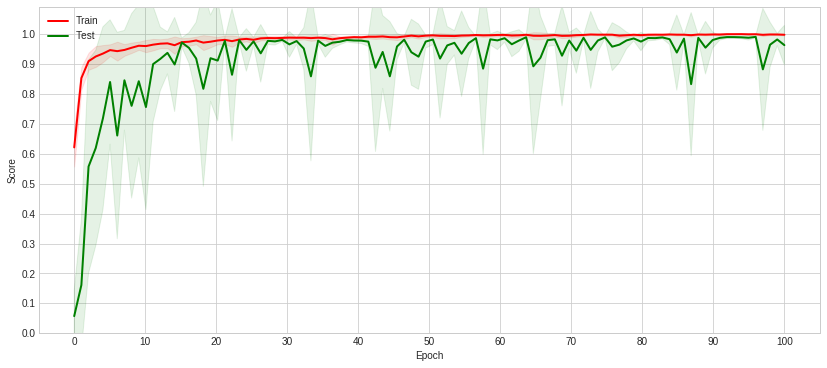

In [33]:
plot_mean_acc(history)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

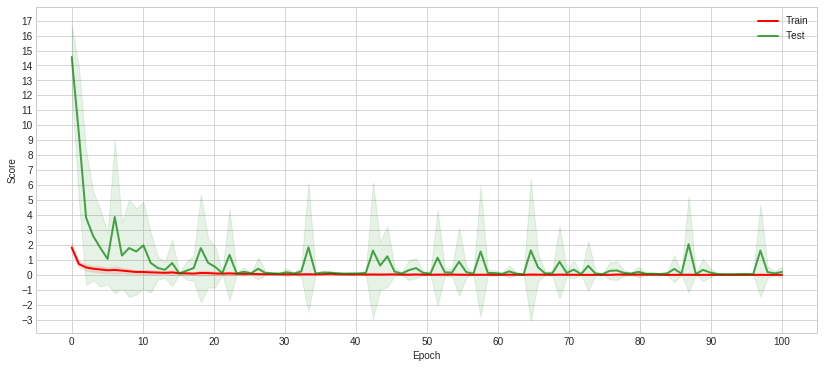

In [35]:
plot_mean_loss(history)